<a href="https://colab.research.google.com/github/bongkyunSON/Fastcampus-ML/blob/main/ML_project_221117.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning Project

 - 데이콘 : 건설기계오일상태분류
 - https://dacon.io/competitions/official/236013/overview/description


1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

## 1. 라이브러리, 데이터 불러오기

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.9 MB/s 
     |████████████████████████████████| 81 kB 8.5 MB/s 
     |████████████████████████████████| 209 kB 54.3 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 50 kB 5.7 MB/s 
     |████████████████████████████████| 112 kB 54.1 MB/s 
     |████████████████████████████████| 147 kB 37.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1cb1dae9b44bc1865172617d80fbf66e6adc73b4f669ecef10a8a996917bdc06
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

In [3]:
# flag setting
data_reducing = False ## memory reducing technique
feature_reducing = False ## feature extraction (curse of dimensionality)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 데이터를 불러옵니다.
base_path = "/content/drive/MyDrive/Colab Notebooks/MachineLearning/data/Construction_machinery/"
train = pd.read_csv(base_path + "train.csv")
test = pd.read_csv(base_path + "test.csv")

## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [6]:
train

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,TRAIN_14090,COMPONENT3,1616,2014,8,200,0,2,201,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,135.4,16,0
14091,TRAIN_14091,COMPONENT1,2784,2013,2,200,0,3,85,0,...,NaN,NaN,NaN,NaN,NaN,0,14.5,117.5,1408,0
14092,TRAIN_14092,COMPONENT3,1788,2008,9,550,0,6,0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,54.0,1301,0
14093,TRAIN_14093,COMPONENT2,2498,2009,19,550,0,2,4,0,...,7.0,8.0,100.0,1625.0,18890.0,0,NaN,44.3,652,0


In [7]:
test

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,TEST_0000,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,TEST_0001,COMPONENT3,2794,2011,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,TEST_0002,COMPONENT2,1982,2010,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,TEST_0003,COMPONENT3,1404,2009,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,TEST_0004,COMPONENT2,8225,2013,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,TEST_6036,COMPONENT3,1714,2014,200,0,0,3,130,1047,0.0,65,5,2,1999,0,0,71.2,1163
6037,TEST_6037,COMPONENT3,4131,2016,200,0,0,5,2,736,0.0,5,0,0,693,0,0,137.8,13
6038,TEST_6038,COMPONENT3,4325,2014,200,0,0,0,0,53,0.0,0,0,0,69,0,0,302.2,13
6039,TEST_6039,COMPONENT2,1364,2013,200,0,0,0,62,2,0.0,0,0,0,5,0,0,51.1,478


### train과 test, columns 차이가 있다 drop 할건지, 0으로 체울건지 아니면 다른 방안으로 null값을 처리할지 고민하기

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  int64  
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [9]:
train.isnull().sum()

ID                         0
COMPONENT_ARBITRARY        0
ANONYMOUS_1                0
YEAR                       0
SAMPLE_TRANSFER_DAY        0
ANONYMOUS_2                0
AG                         0
AL                         0
B                          0
BA                         0
BE                         0
CA                         0
CD                      1394
CO                         0
CR                         0
CU                         0
FH2O                   10205
FNOX                   10205
FOPTIMETHGLY           10205
FOXID                  10205
FSO4                   10205
FTBN                   10205
FE                         0
FUEL                   10205
H2O                        0
K                       2299
LI                         0
MG                         0
MN                         0
MO                         0
NA                         0
NI                         0
P                          0
PB                         0
PQINDEX       

### F로 시작하는 컬럼들과 U로 시작하는 컬럼들의 결측치가 패턴을 보이는것같다

In [10]:
train.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR',
       'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI',
       'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100',
       'V40', 'ZN', 'Y_LABEL'],
      dtype='object')

0    12892
1     1203
Name: Y_LABEL, dtype: int64

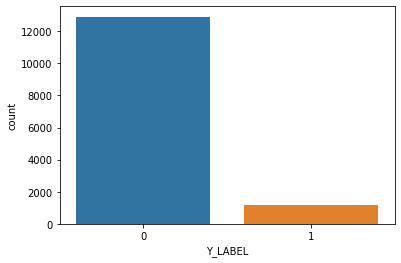

In [11]:
#불량이 10배정도 차이난다
display(train["Y_LABEL"].value_counts())
sns.countplot(data=train, x="Y_LABEL")

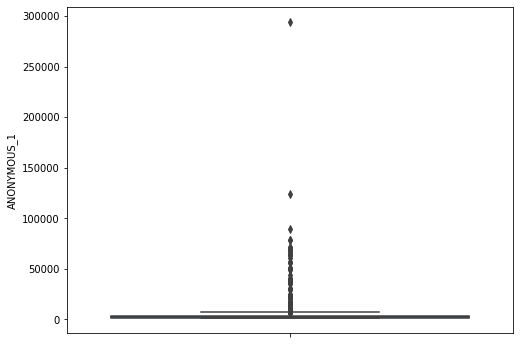

In [12]:
#ANONYMOUS_1 - 이 column은 뭐지??? 아웃라이어가 이상하다....
plt.figure(figsize = (8,6))
sns.boxplot(data=train, y="ANONYMOUS_1")

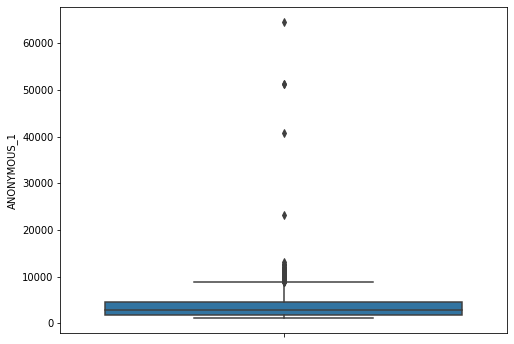

In [13]:
Y_1 = train[train["Y_LABEL"] ==1]
Y_1

plt.figure(figsize = (8,6))
sns.boxplot(data=Y_1, y="ANONYMOUS_1")

In [14]:
ANONYMOUS_1_20000 = train[train["ANONYMOUS_1"] > 300000]
ANONYMOUS_1_20000#[ANONYMOUS_1_20000["Y_LABEL"] == 1]

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL


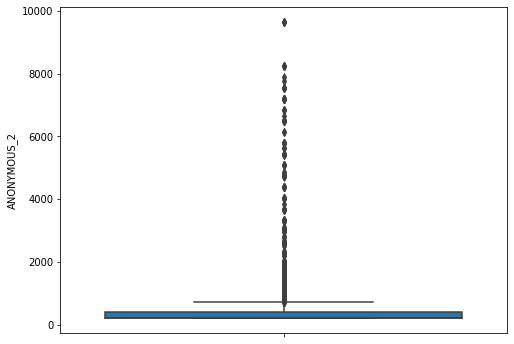

In [15]:
#ANONYMOUS_2 - 이 column은 뭐지??? 아웃라이어가 이상하다....
plt.figure(figsize = (8,6))
sns.boxplot(data=train, y="ANONYMOUS_2")

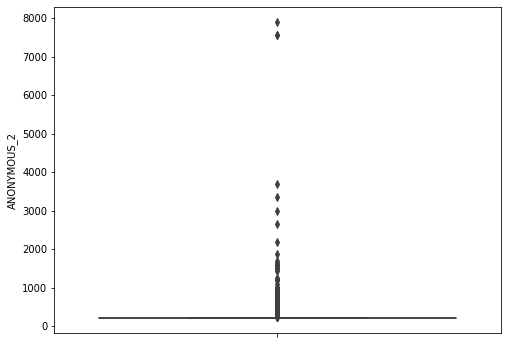

In [16]:
Y_1 = train[train["Y_LABEL"] ==1]
Y_1

plt.figure(figsize = (8,6))
sns.boxplot(data=Y_1, y="ANONYMOUS_2")

In [17]:
ANONYMOUS_2_2000 = train[train["ANONYMOUS_2"] > 2000]
ANONYMOUS_2_2000

,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
59,TRAIN_00059,COMPONENT2,8483,2018,2,7550,0,0,3,0,...,3.0,5.0,19.0,428.0,1304.0,0,NaN,58.1,382,1
383,TRAIN_00383,COMPONENT3,5890,2017,3,5100,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,140.8,11,0
436,TRAIN_00436,COMPONENT4,6780,2017,6,5800,0,5,2,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,83.4,1505,0
647,TRAIN_00647,COMPONENT2,3389,2017,3,2650,0,0,1,0,...,85.0,102.0,666.0,8788.0,11935.0,0,NaN,57.4,356,0
983,TRAIN_00983,COMPONENT1,6925,2017,2,6150,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,0,12.6,87.4,936,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13469,TRAIN_13469,COMPONENT3,123788,2017,0,6654,0,13,1,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,124.3,74,0
13705,TRAIN_13705,COMPONENT1,4130,2017,6,3000,0,68,3,0,...,NaN,NaN,NaN,NaN,NaN,0,10.2,68.8,1042,1
13965,TRAIN_13965,COMPONENT2,7402,2017,7,6500,0,5,23,0,...,16.0,32.0,131.0,6895.0,29629.0,0,NaN,66.2,126,0
14040,TRAIN_14040,COMPONENT1,5519,2017,4,4750,0,0,10,0,...,NaN,NaN,NaN,NaN,NaN,0,8.3,47.8,859,0


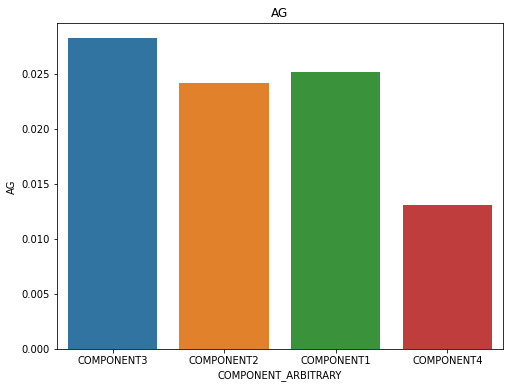

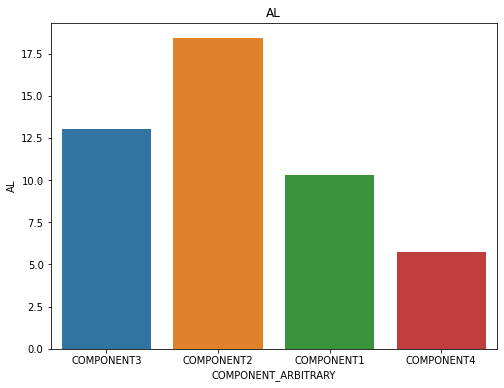

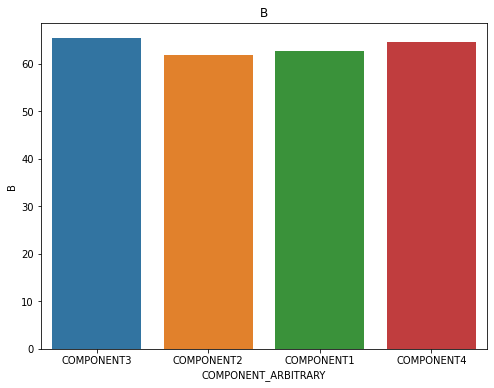

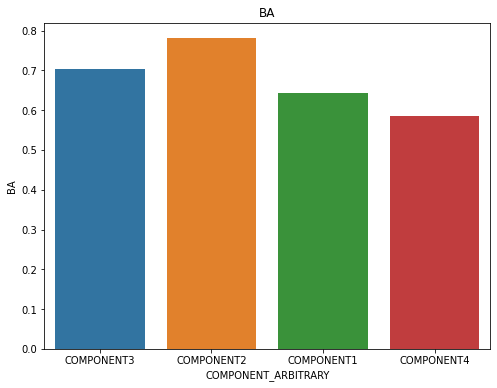

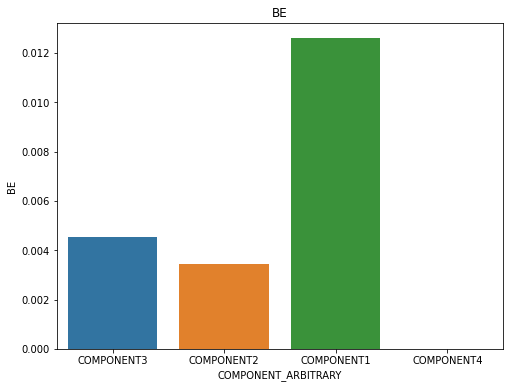

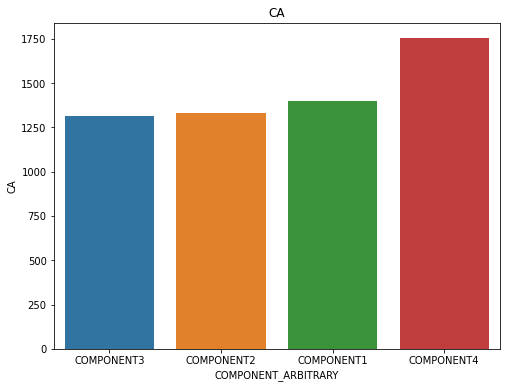

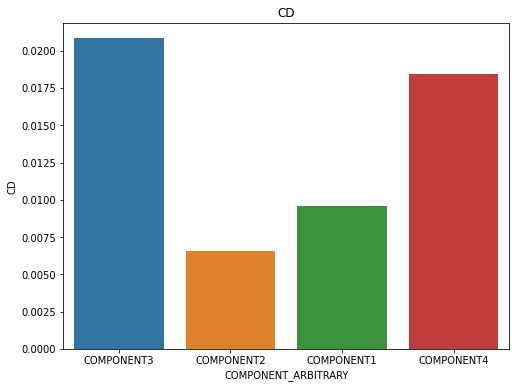

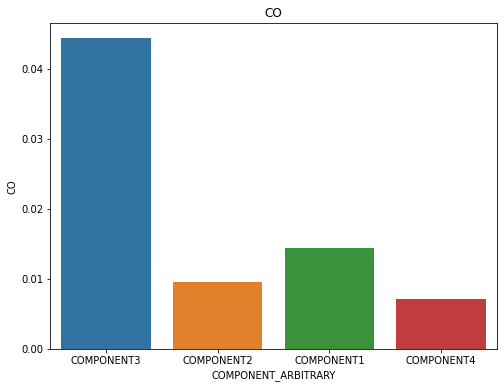

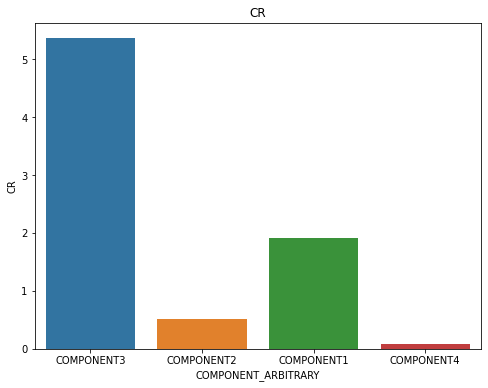

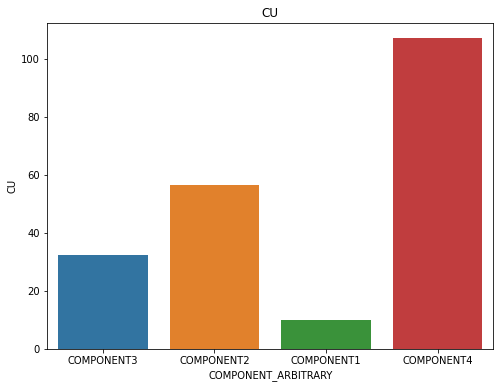

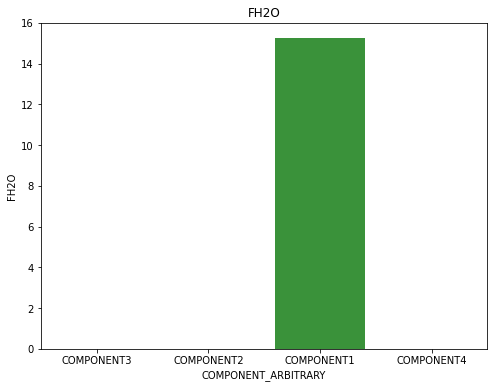

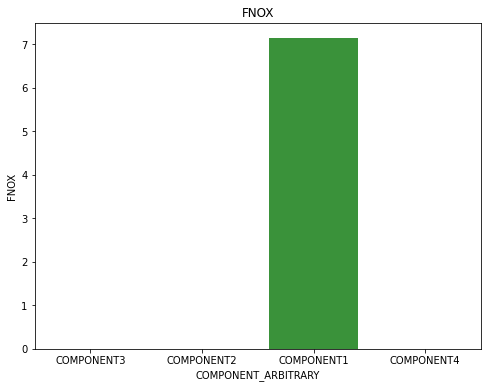

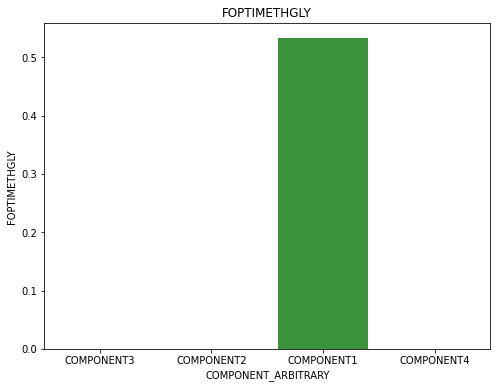

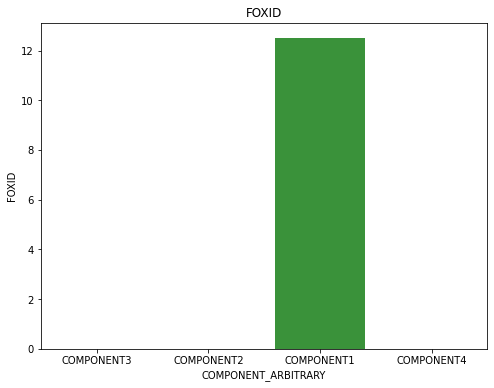

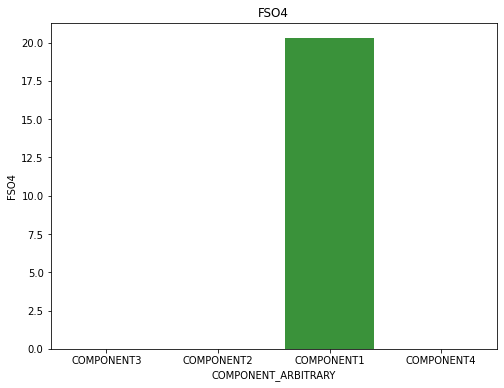

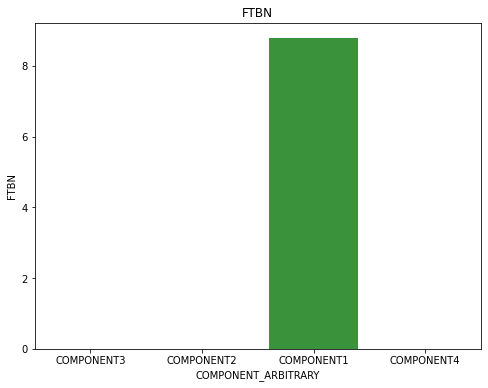

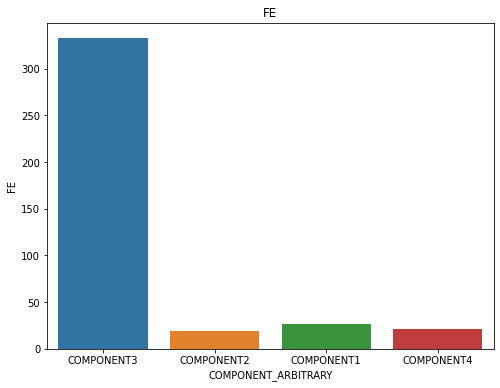

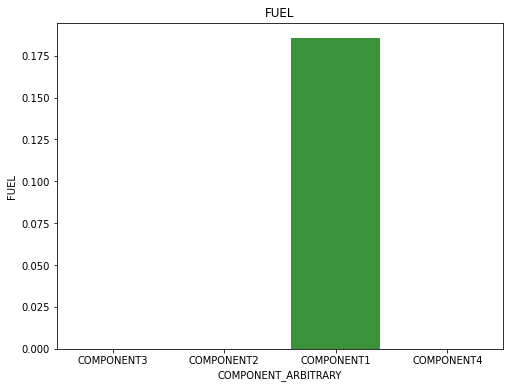

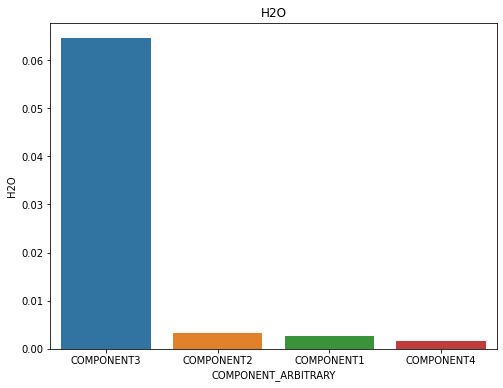

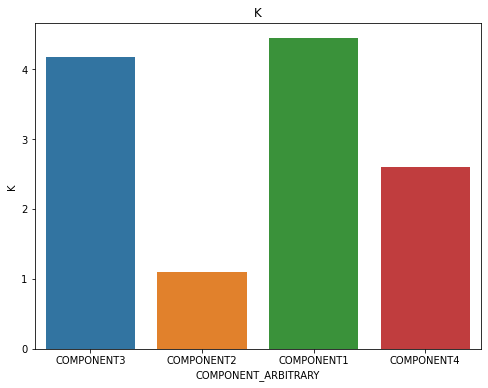

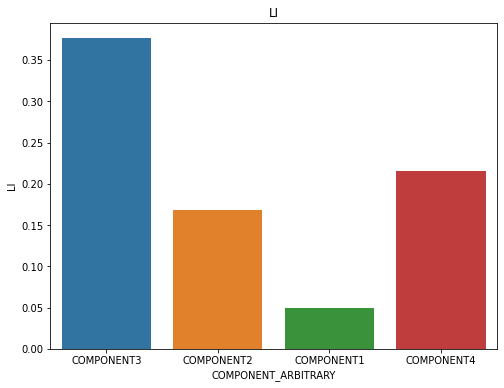

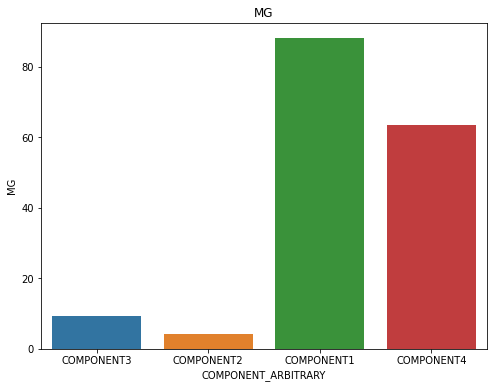

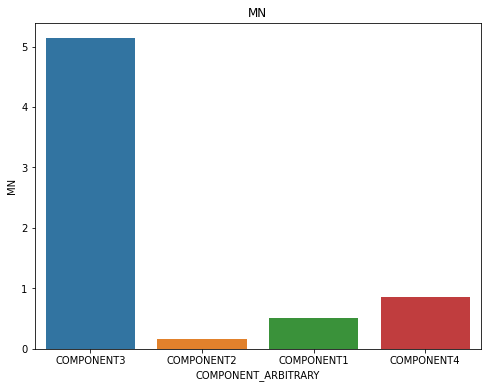

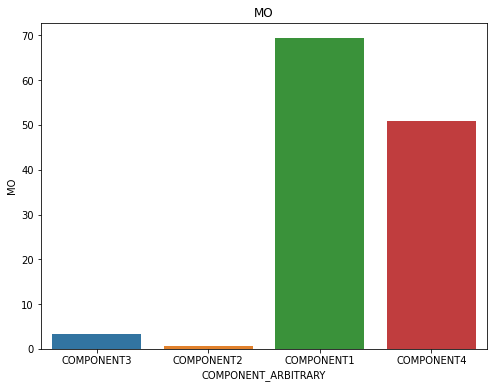

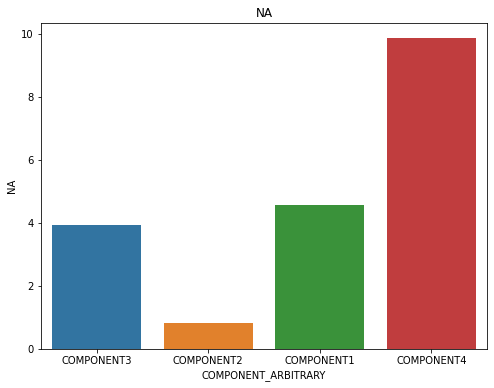

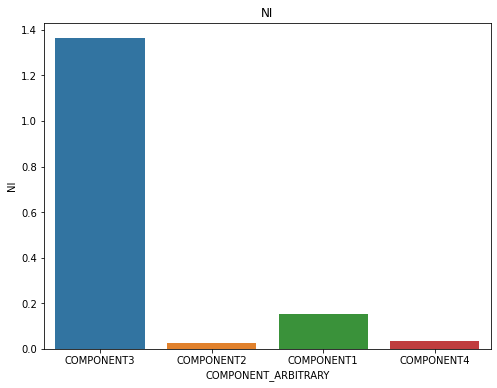

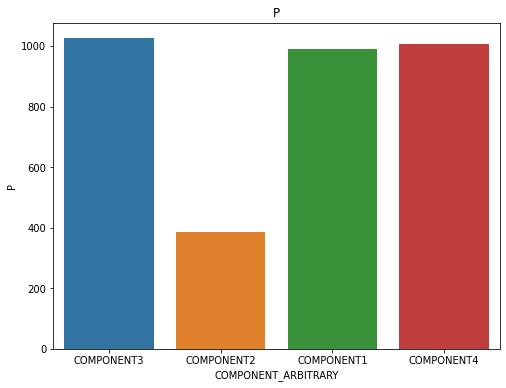

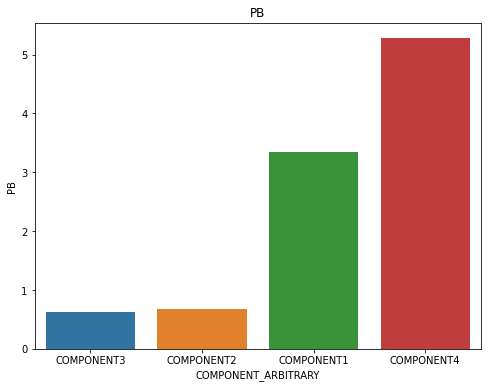

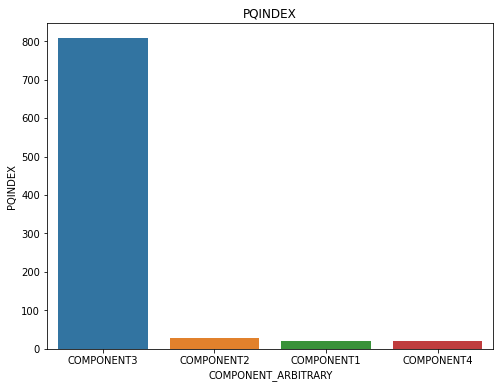

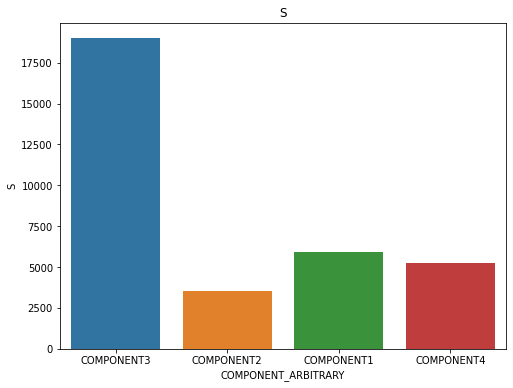

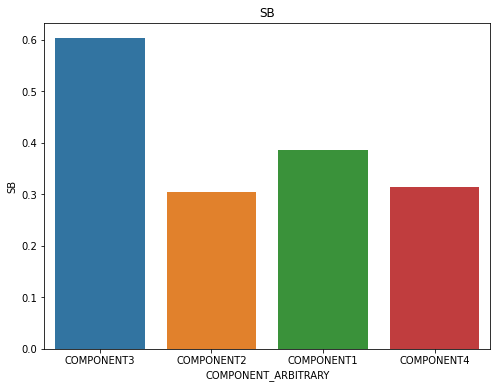

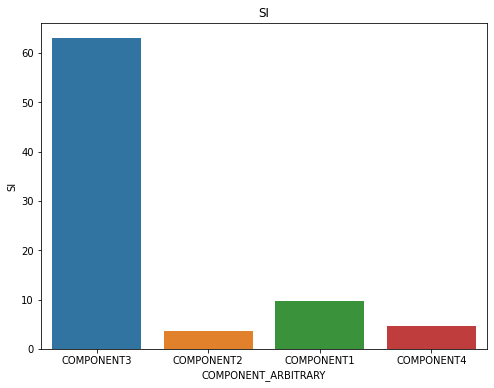

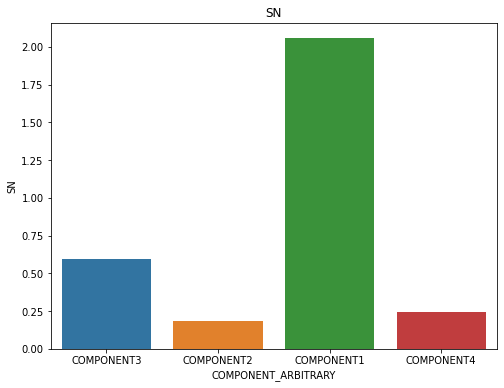

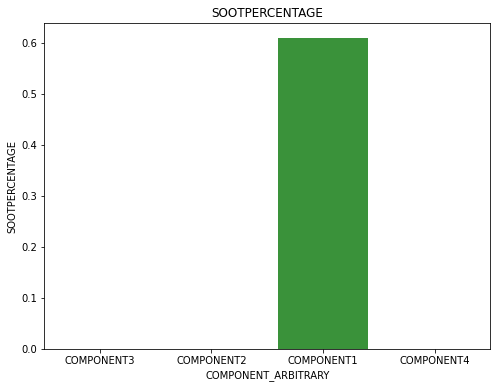

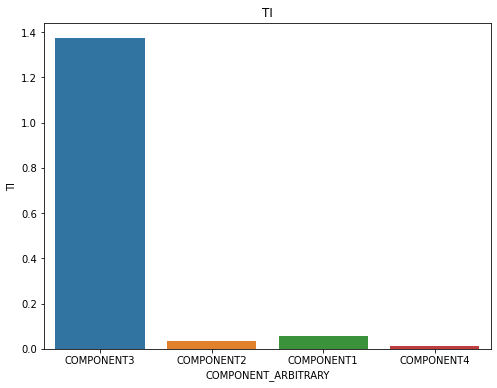

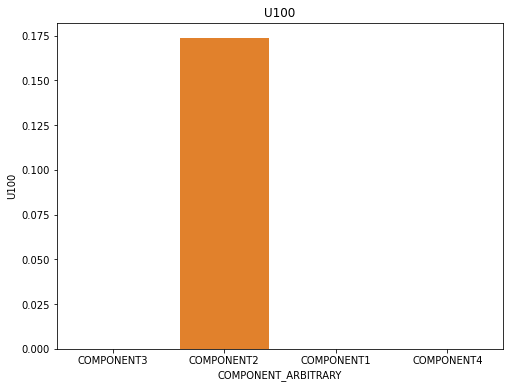

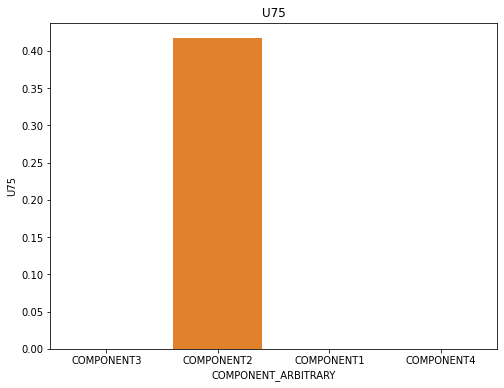

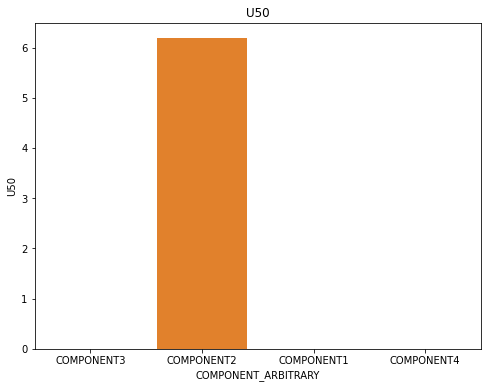

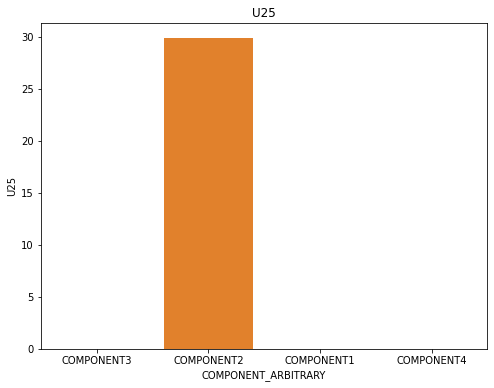

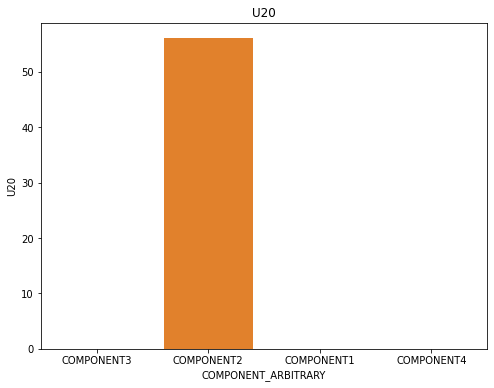

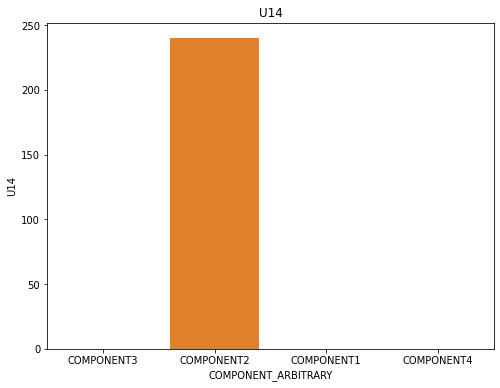

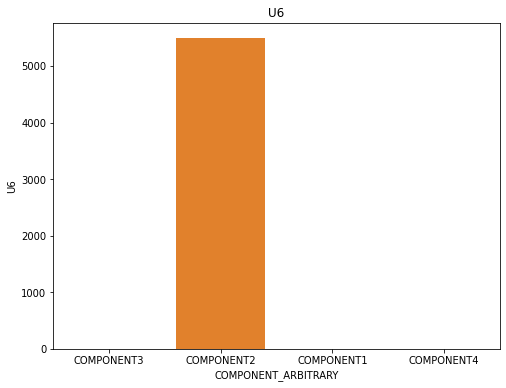

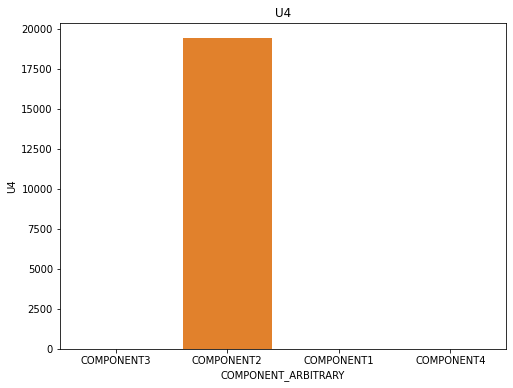

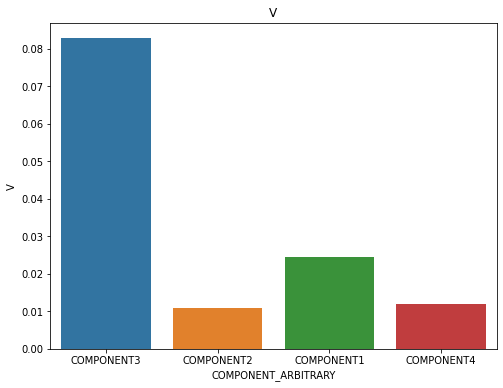

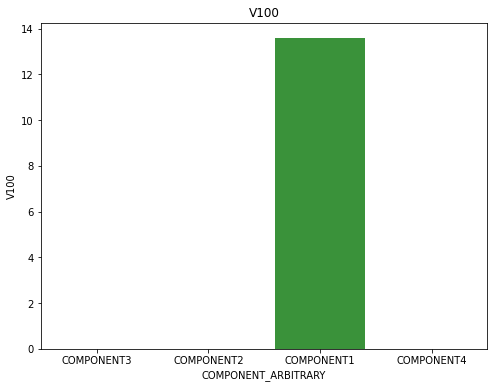

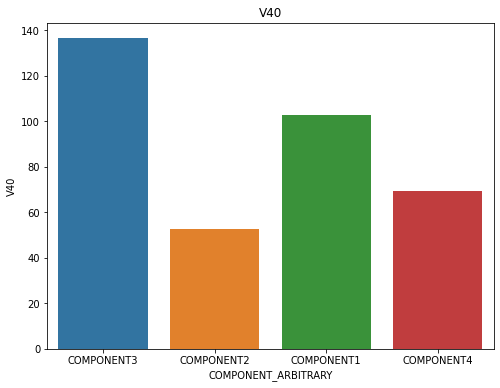

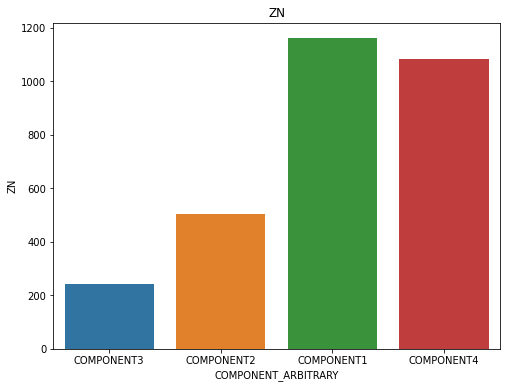

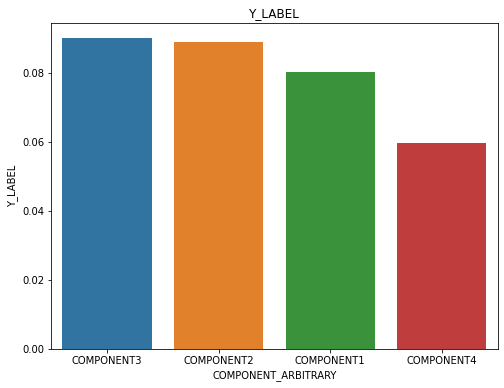

In [18]:
train_list = ['AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI',
       'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100',
       'V40', 'ZN', 'Y_LABEL']



for n in range(len(train_list)):
    plt.figure(figsize=(8, 6))
    plt.title(train_list[n])
    sns.barplot(data=train, x="COMPONENT_ARBITRARY", y=train_list[n], ci=None)
    plt.show()

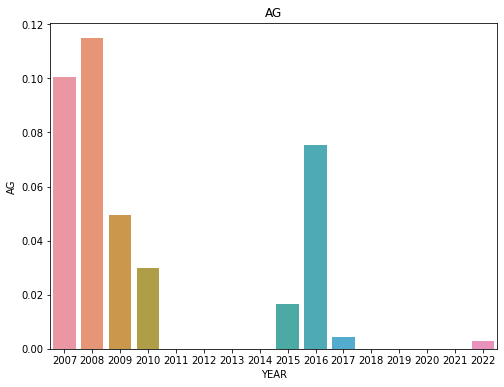

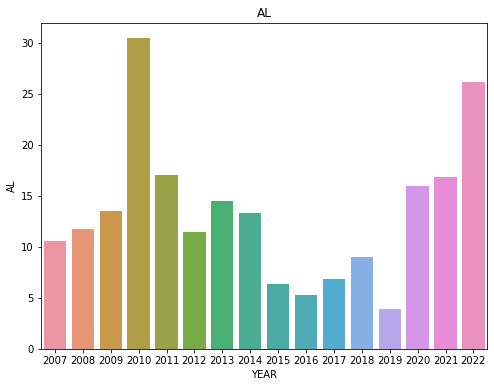

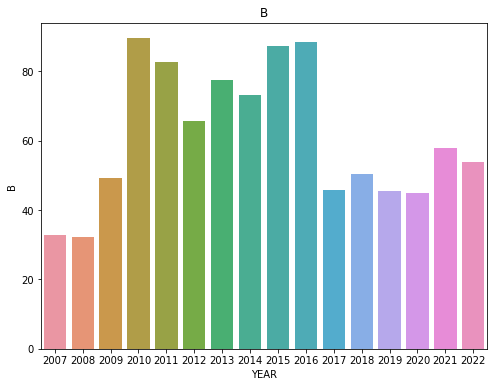

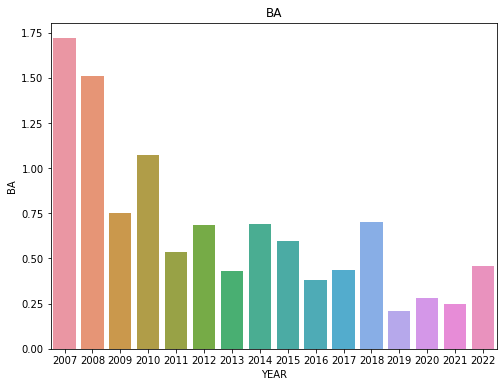

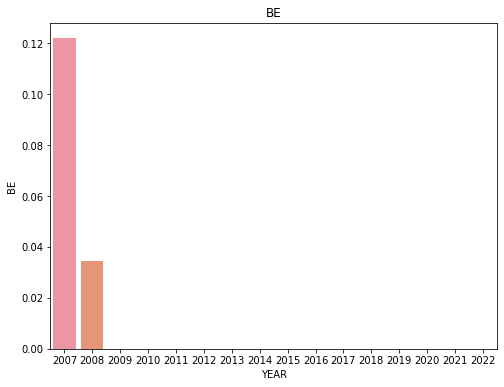

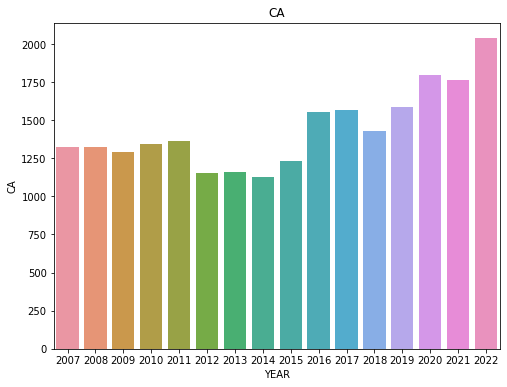

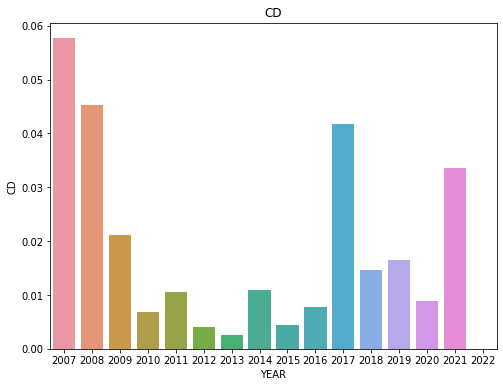

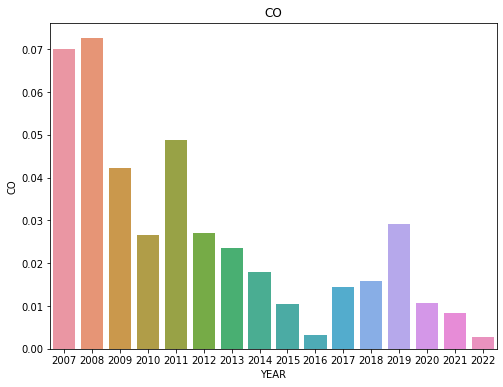

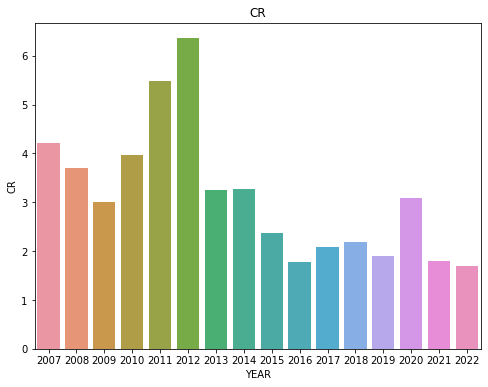

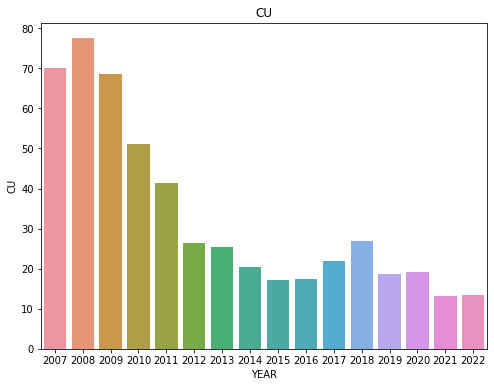

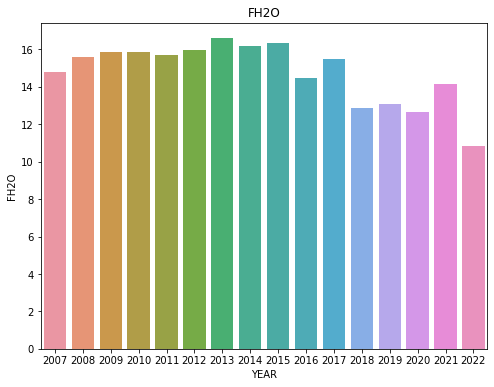

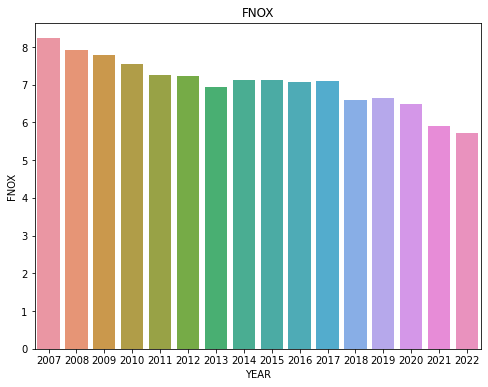

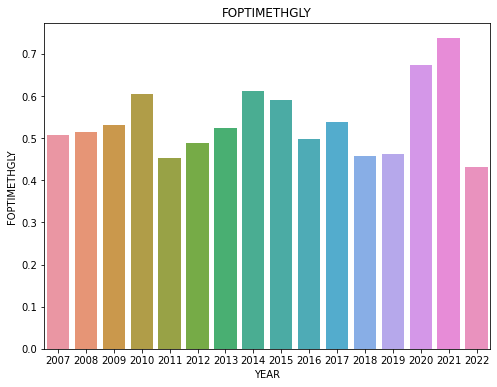

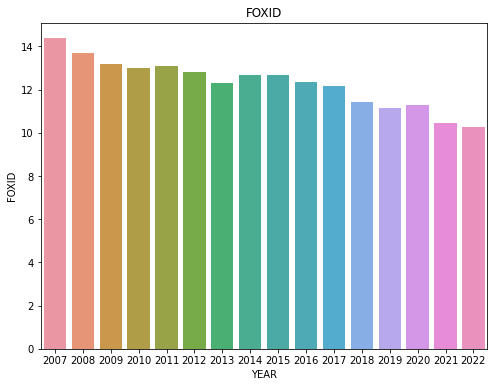

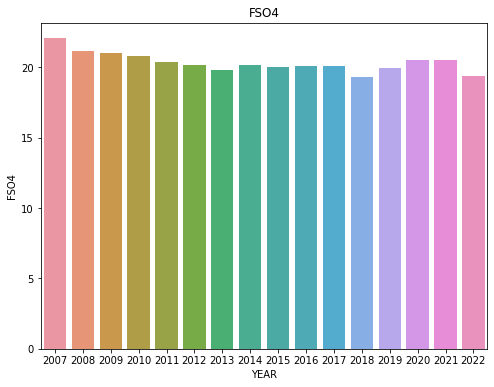

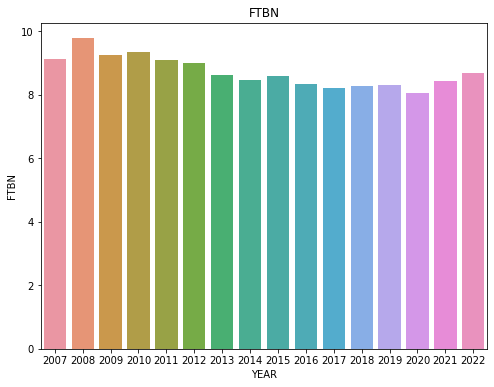

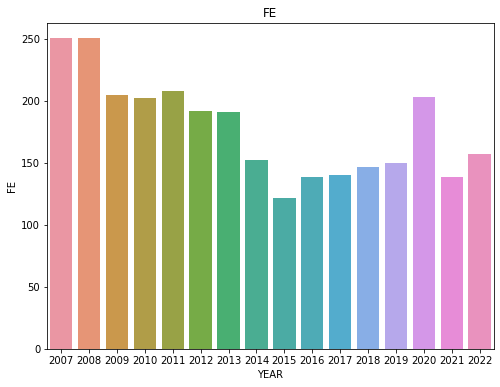

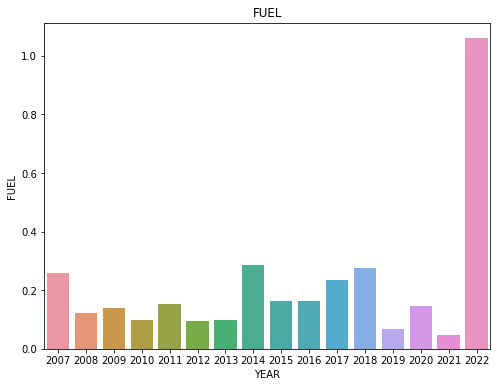

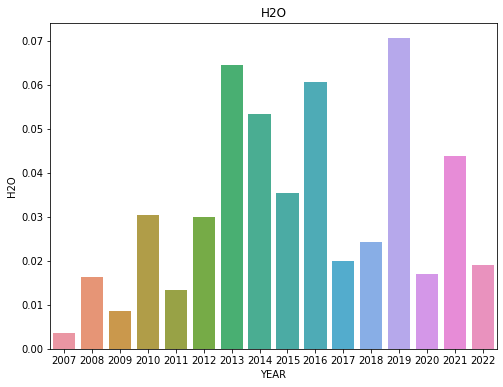

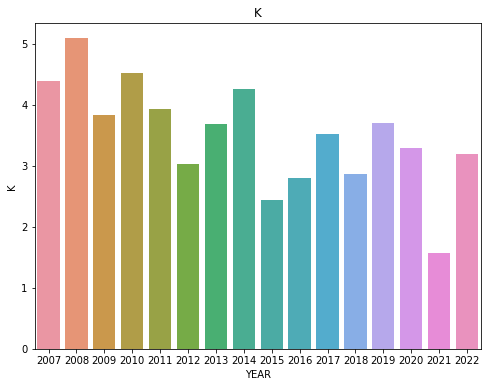

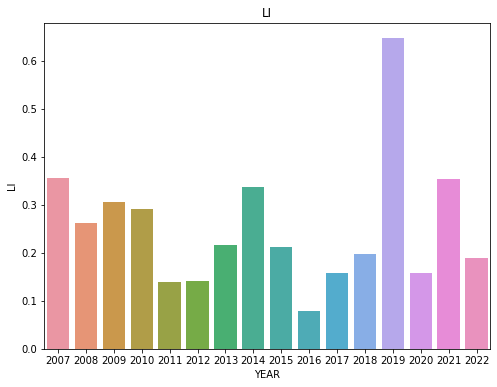

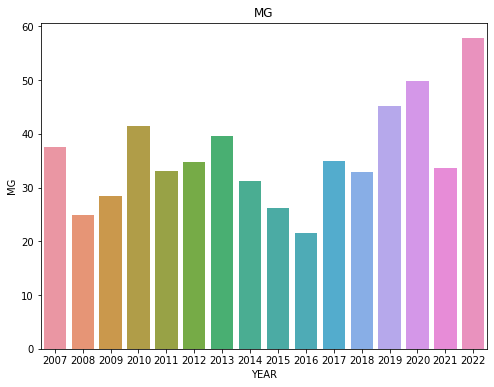

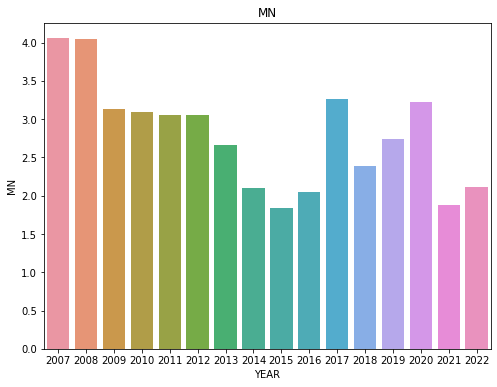

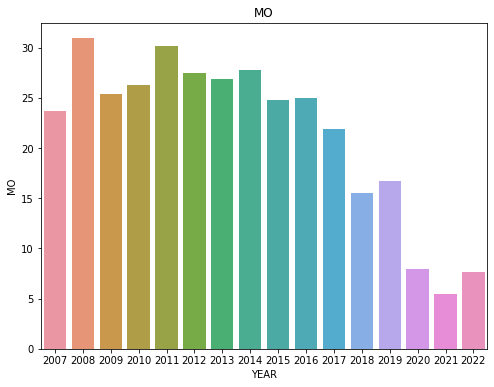

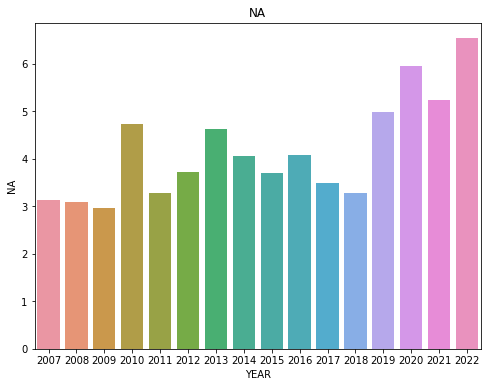

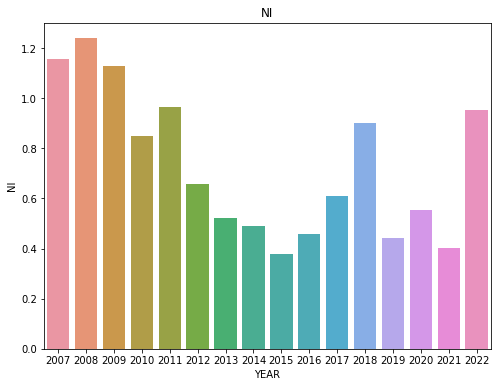

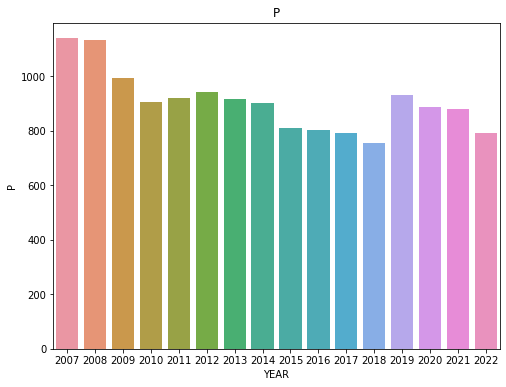

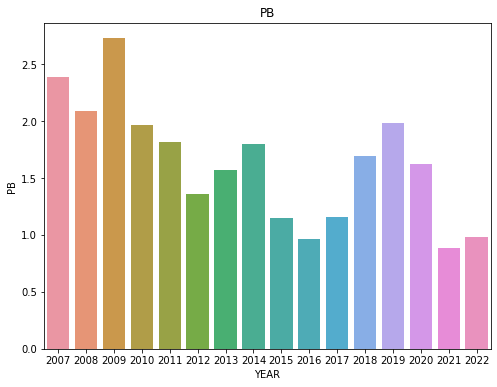

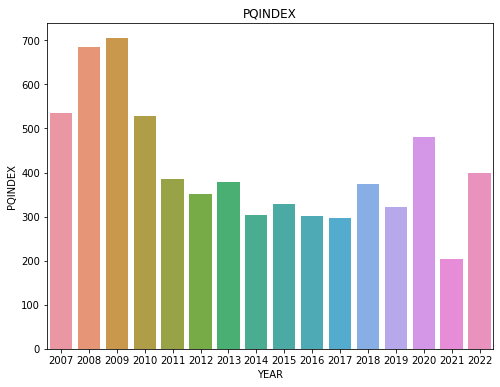

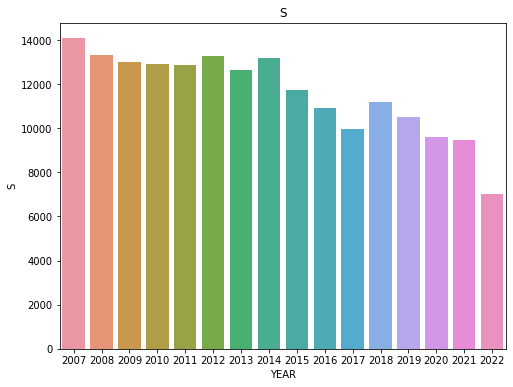

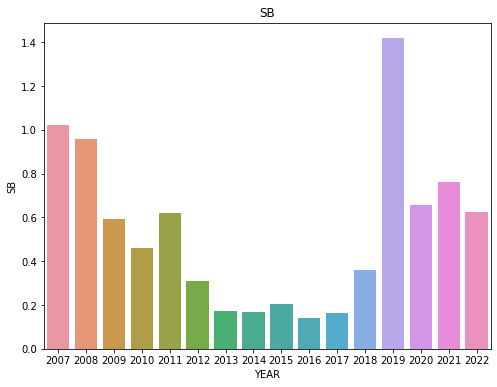

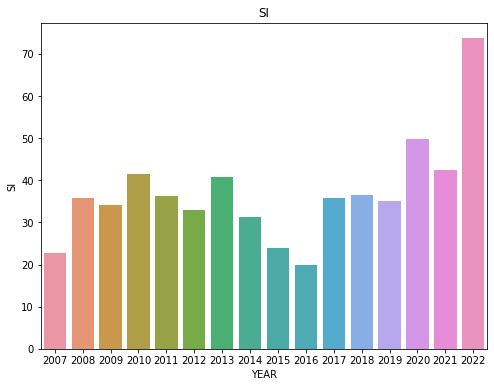

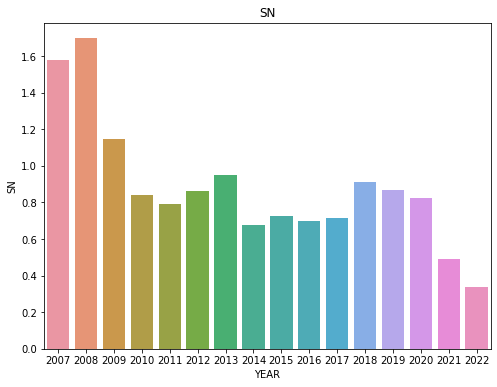

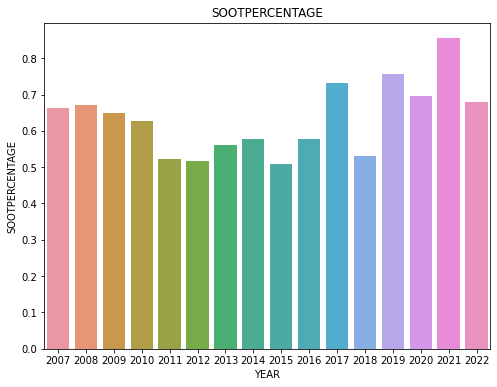

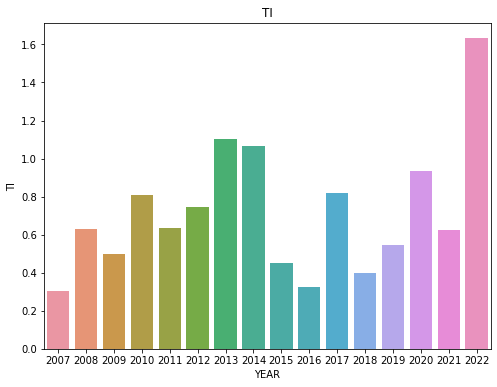

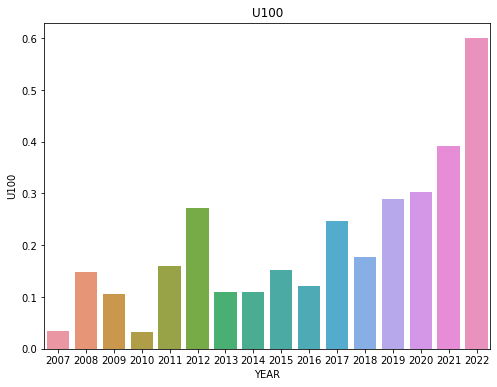

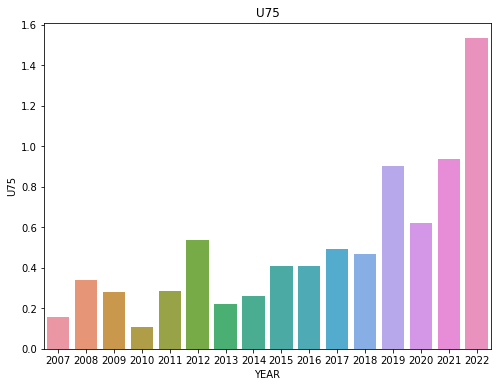

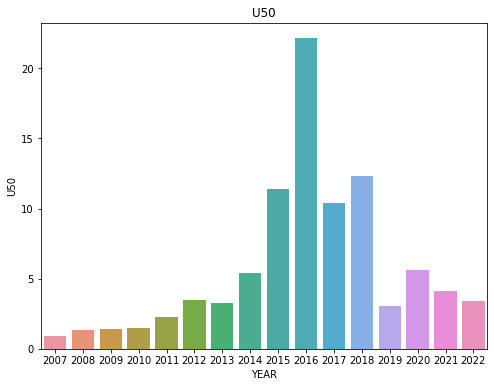

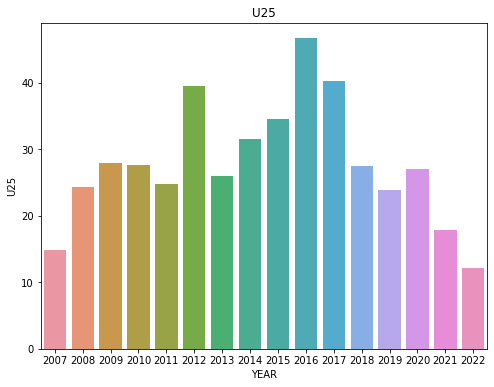

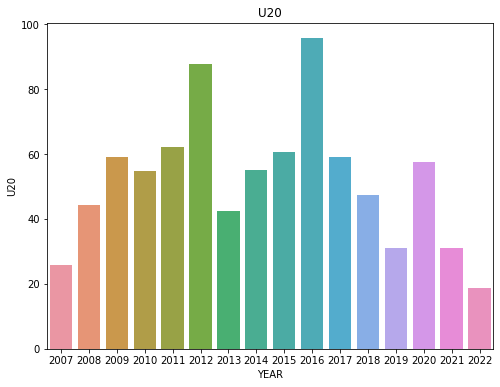

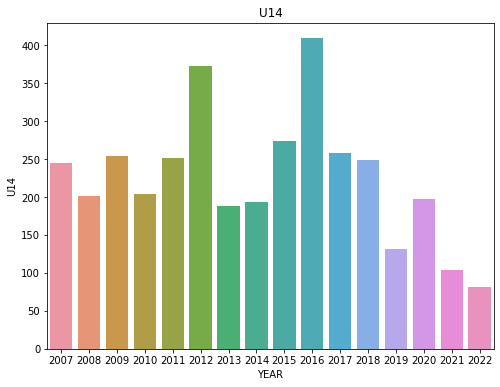

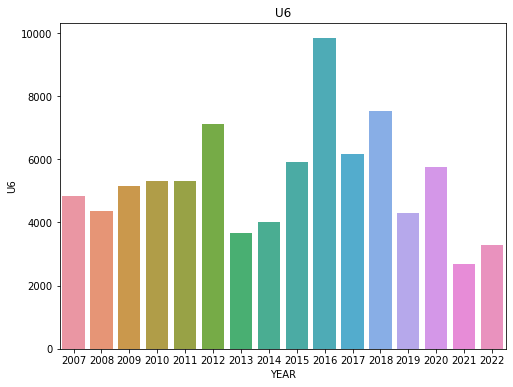

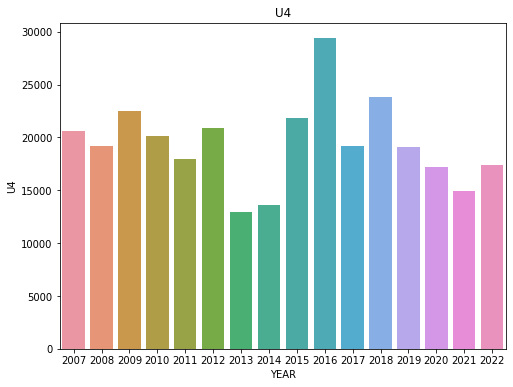

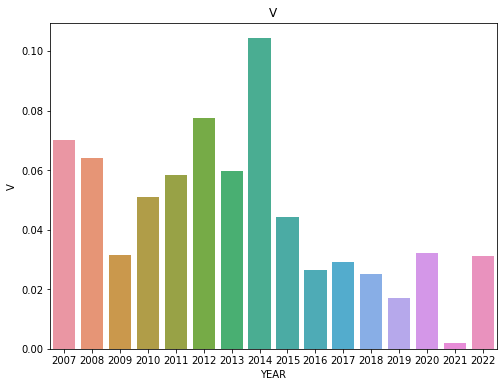

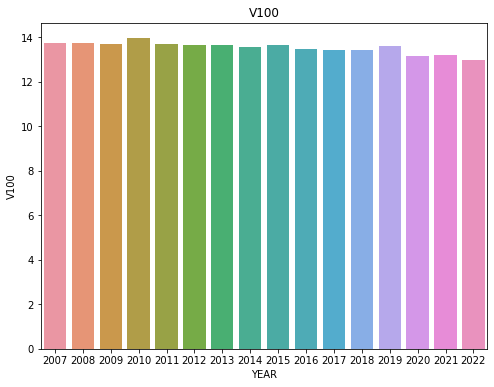

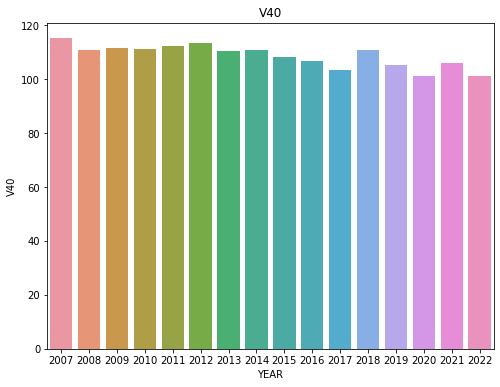

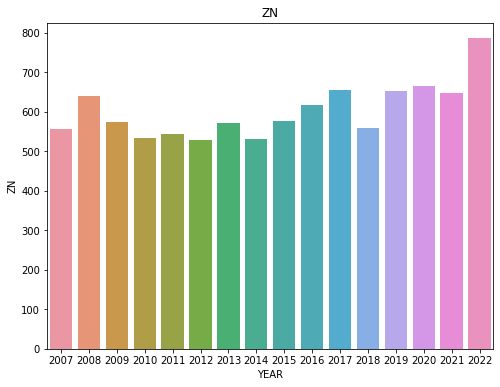

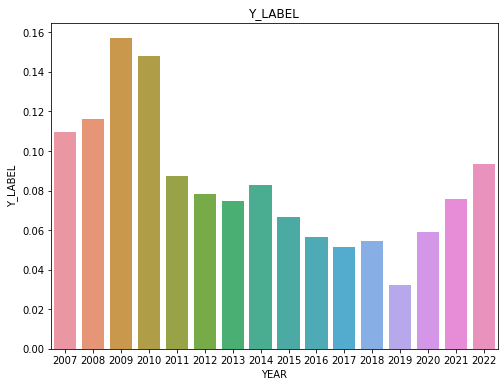

In [19]:
train_list = ['AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI',
       'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100',
       'V40', 'ZN', 'Y_LABEL']



for n in range(len(train_list)):
    plt.figure(figsize=(8, 6))
    plt.title(train_list[n])
    sns.barplot(data=train, x="YEAR", y=train_list[n], ci=None)
    plt.show()

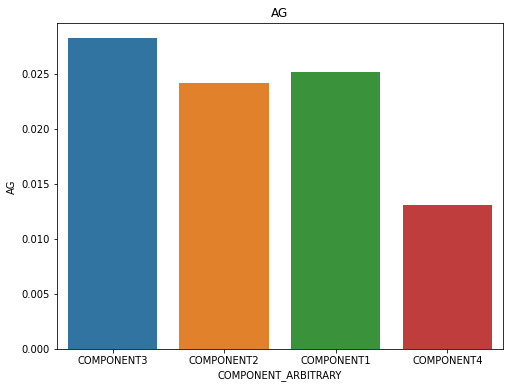

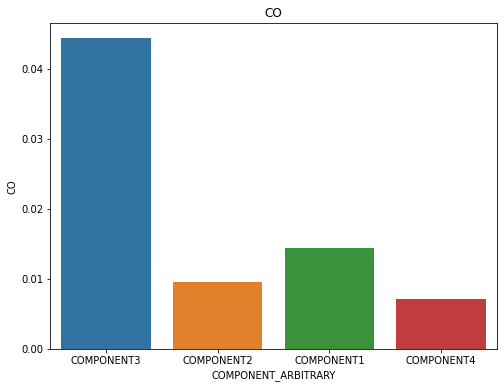

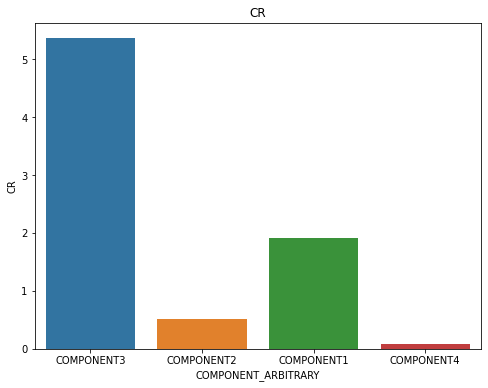

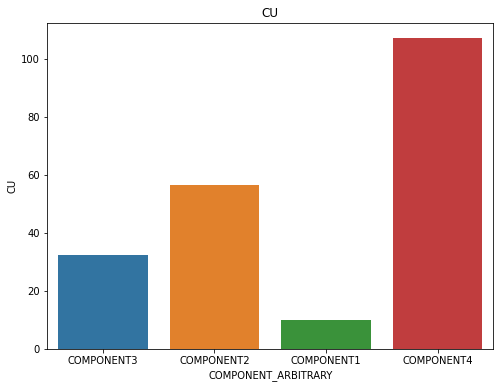

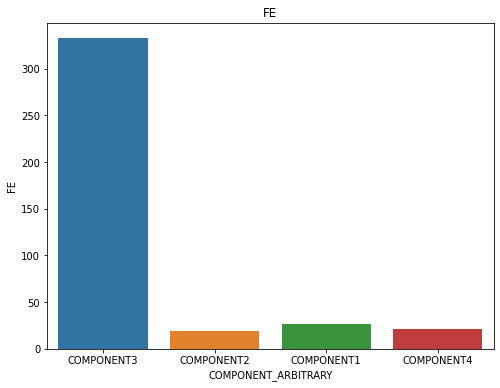

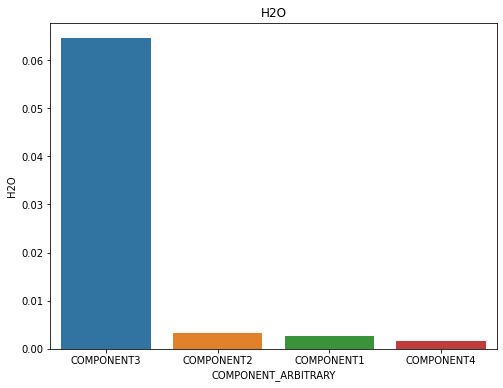

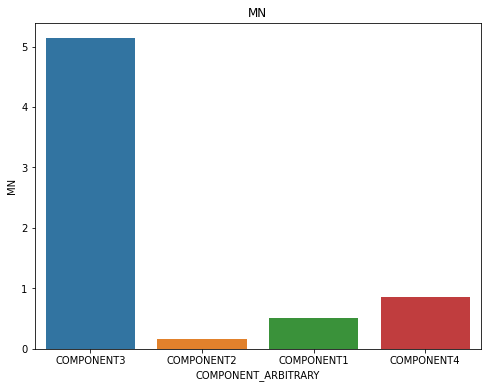

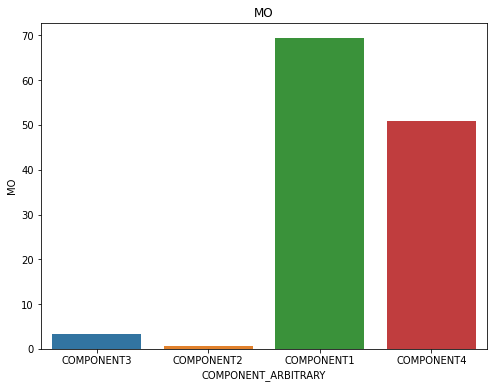

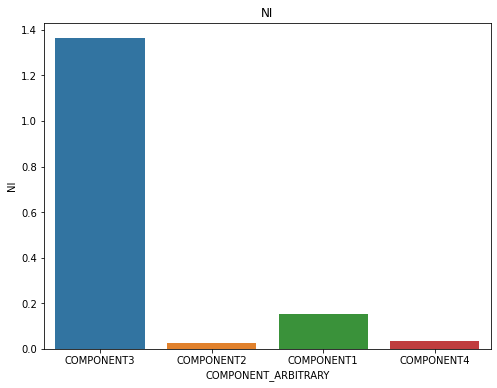

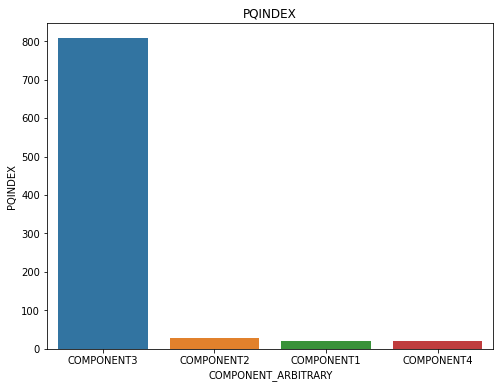

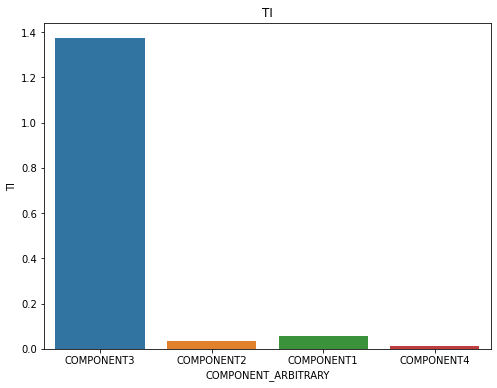

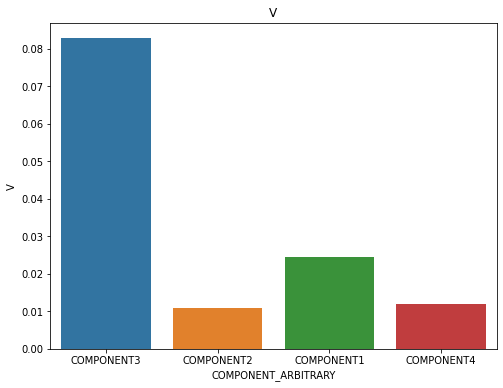

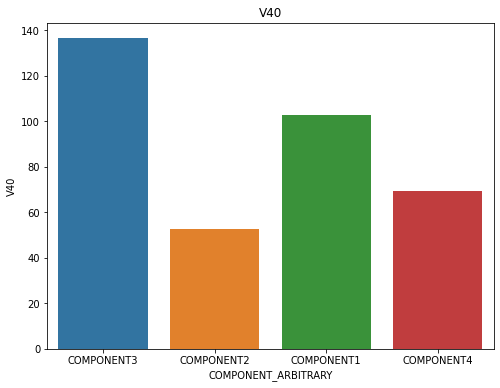

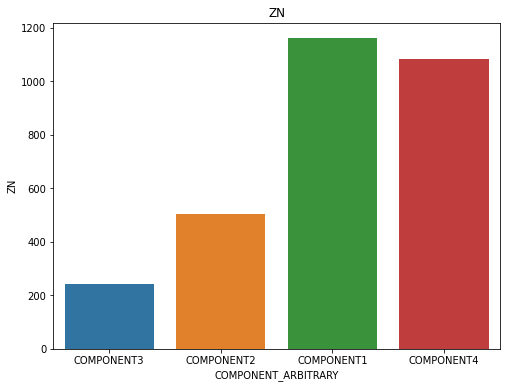

In [20]:
test_list = ['AG','CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN']



for n in range(len(test_list)):
    plt.figure(figsize=(8, 6))
    plt.title(test_list[n])
    sns.barplot(data=train, x="COMPONENT_ARBITRARY", y=test_list[n], ci=None)
    plt.show()

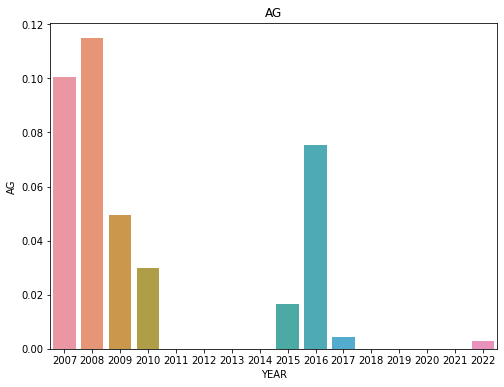

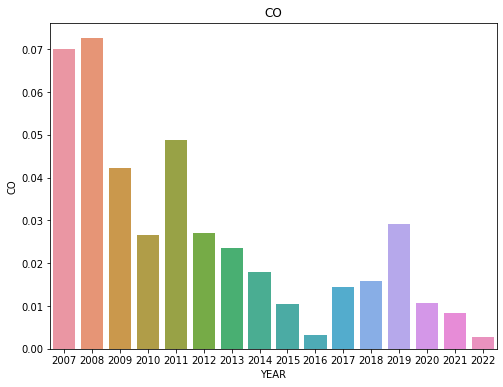

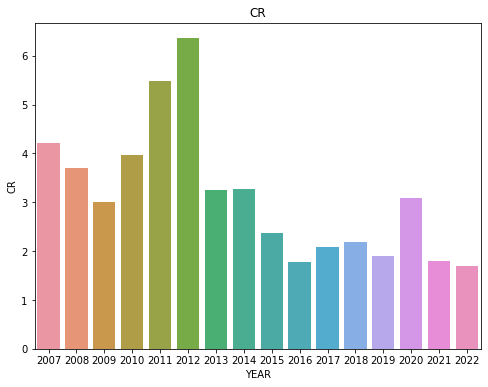

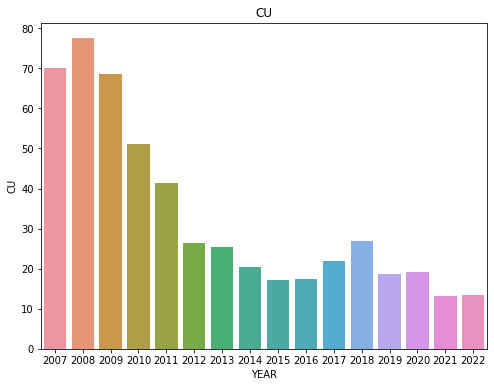

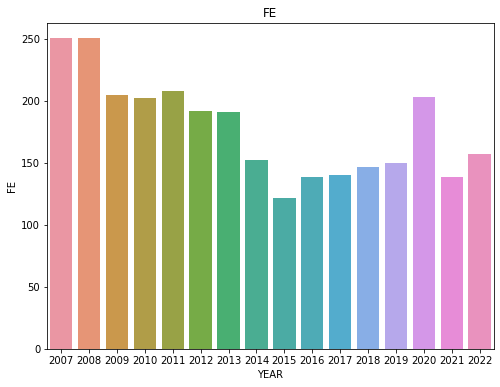

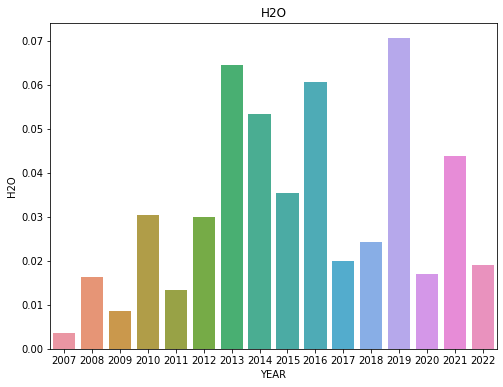

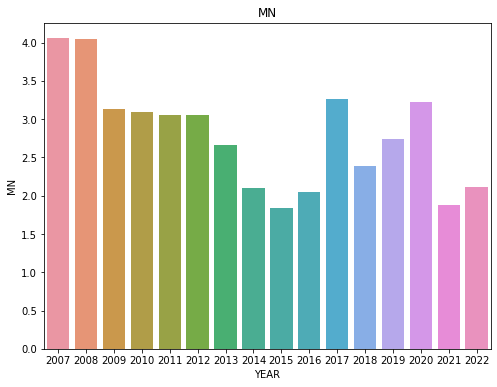

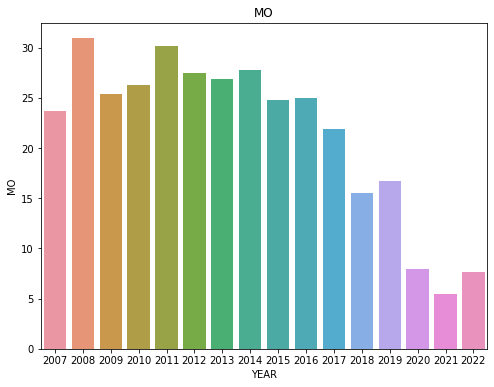

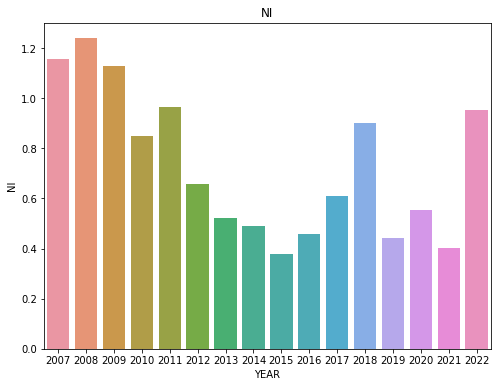

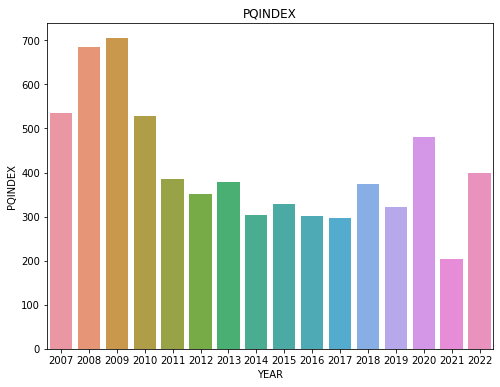

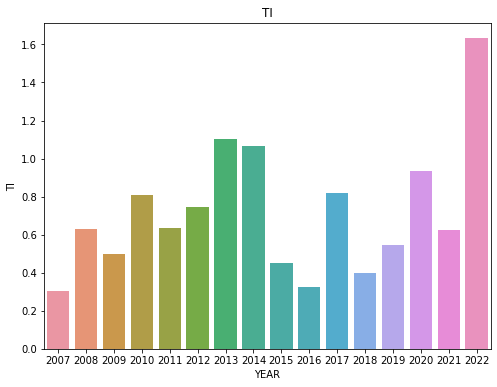

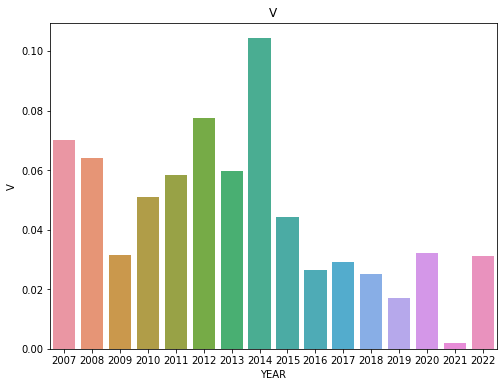

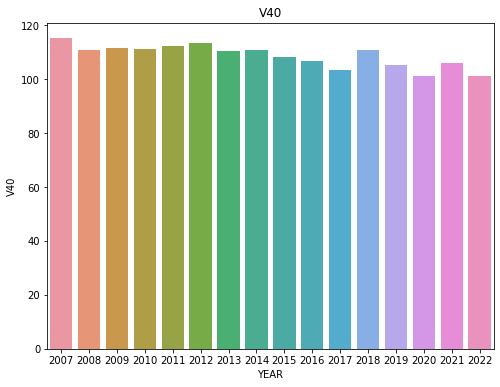

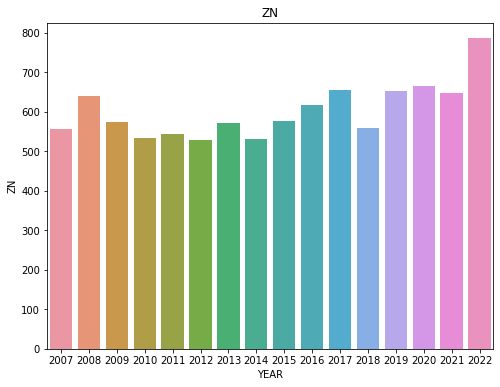

In [21]:
test_list = ['AG','CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN']



for n in range(len(test_list)):
    plt.figure(figsize=(8, 6))
    plt.title(test_list[n])
    sns.barplot(data=train, x="YEAR", y=test_list[n], ci=None)
    plt.show()

In [22]:
test.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN'],
      dtype='object')

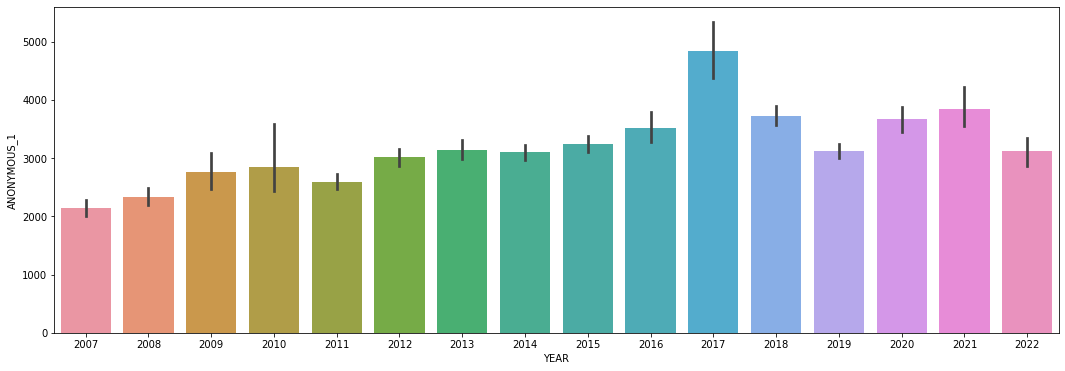

In [23]:
plt.figure(figsize = (18,6))
sns.barplot(data=train, x="YEAR", y="ANONYMOUS_1")

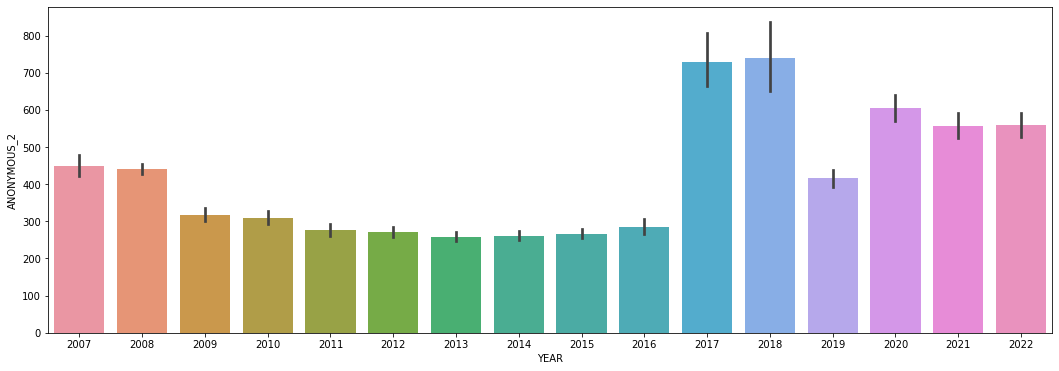

In [24]:
plt.figure(figsize = (18,6))
sns.barplot(data=train, x="YEAR", y="ANONYMOUS_2")

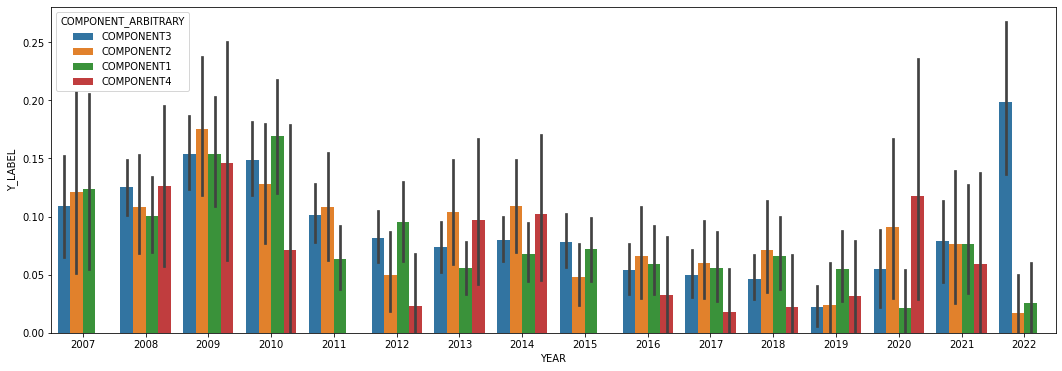

In [25]:
plt.figure(figsize = (18,6))
sns.barplot(data=train, x="YEAR", y="Y_LABEL", hue="COMPONENT_ARBITRARY")

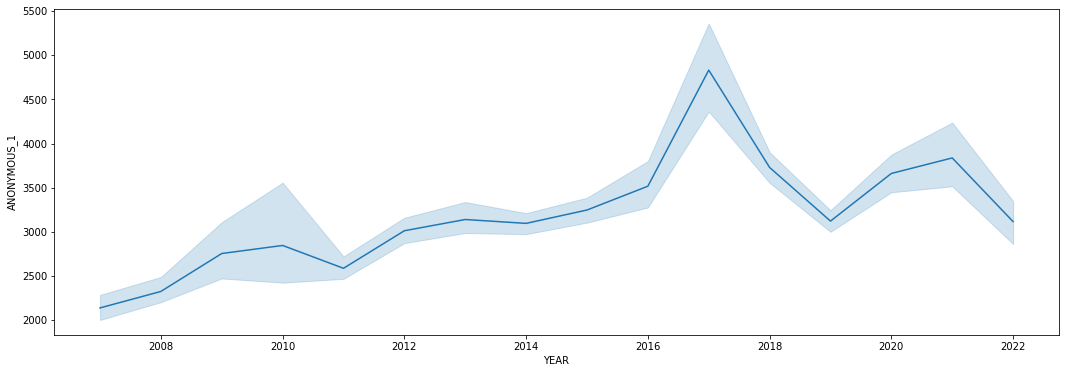

In [26]:
plt.figure(figsize = (18,6))
sns.lineplot(data=train, x="YEAR", y="ANONYMOUS_1")

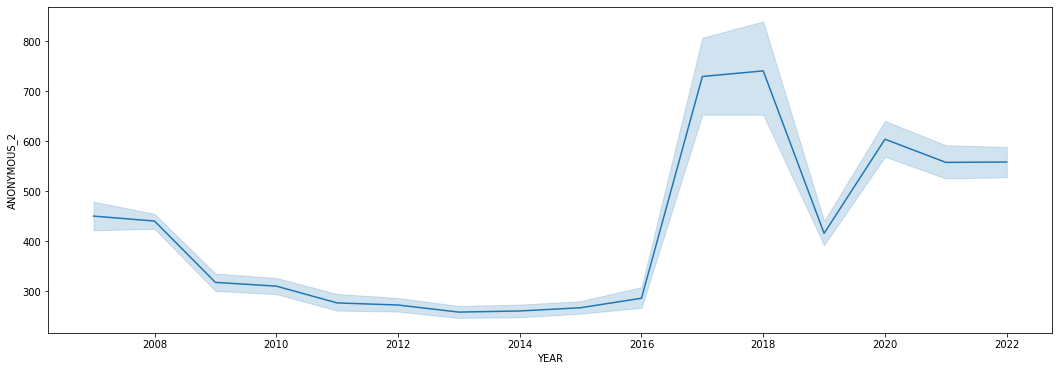

In [27]:
plt.figure(figsize = (18,6))
sns.lineplot(data=train, x="YEAR", y="ANONYMOUS_2")

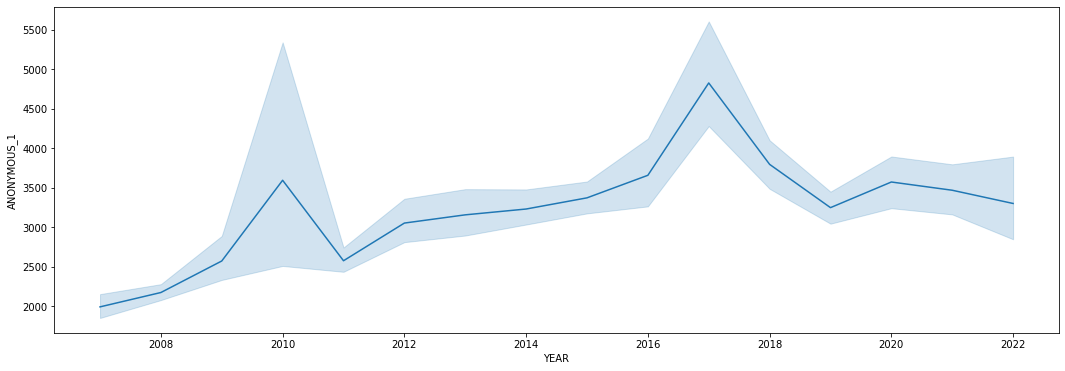

In [28]:
plt.figure(figsize = (18,6))
sns.lineplot(data=test, x="YEAR", y="ANONYMOUS_1")

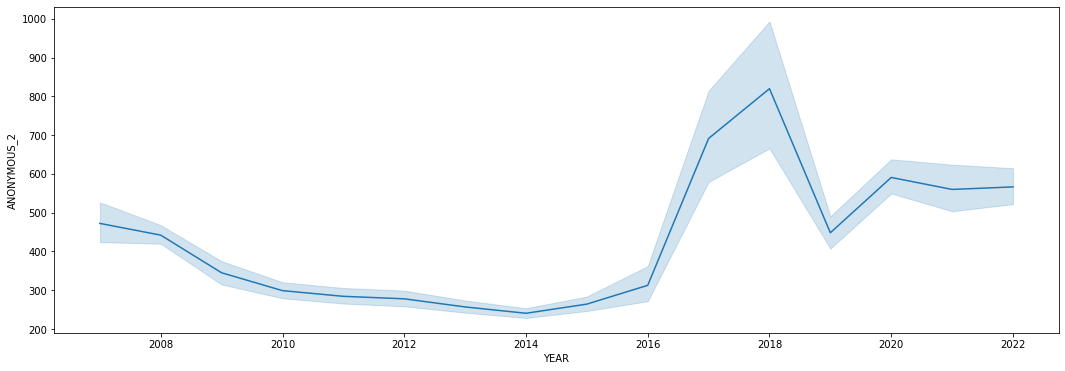

In [29]:
plt.figure(figsize = (18,6))
sns.lineplot(data=test, x="YEAR", y="ANONYMOUS_2")

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  int64  
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

In [31]:
# train 결측치, drop 처리
train = train.fillna(0)

COMPONENT_ARBITRARY_map = {"COMPONENT1" : 1, "COMPONENT2" : 2, "COMPONENT3" : 3, "COMPONENT4" : 4}
train.COMPONENT_ARBITRARY = train.COMPONENT_ARBITRARY.map(COMPONENT_ARBITRARY_map)

train = train.drop(['ID', 'SAMPLE_TRANSFER_DAY', 'YEAR',], axis = 1)

In [32]:
train

,COMPONENT_ARBITRARY,ANONYMOUS_1,ANONYMOUS_2,AG,AL,B,BA,BE,CA,CD,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,3,1486,200,0,3,93,0,0,3059,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,154.0,75,0
1,2,1350,375,0,2,19,0,0,2978,0.0,...,2.0,4.0,6.0,216.0,1454.0,0,0.0,44.0,652,0
2,2,2415,200,0,110,1,1,0,17,0.0,...,0.0,3.0,39.0,11261.0,41081.0,0,0.0,72.6,412,1
3,3,7389,200,0,8,3,0,0,1960,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,133.3,7,0
4,3,3954,200,0,1,157,0,0,71,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,133.1,128,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,3,1616,200,0,2,201,1,0,6,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,135.4,16,0
14091,1,2784,200,0,3,85,0,0,2945,0.0,...,0.0,0.0,0.0,0.0,0.0,0,14.5,117.5,1408,0
14092,3,1788,550,0,6,0,1,0,13,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,54.0,1301,0
14093,2,2498,550,0,2,4,0,0,2244,0.0,...,7.0,8.0,100.0,1625.0,18890.0,0,0.0,44.3,652,0


In [33]:
train.columns

Index(['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'ANONYMOUS_2', 'AG', 'AL', 'B',
       'BA', 'BE', 'CA', 'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX',
       'FOPTIMETHGLY', 'FOXID', 'FSO4', 'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI',
       'MG', 'MN', 'MO', 'NA', 'NI', 'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI',
       'SN', 'SOOTPERCENTAGE', 'TI', 'U100', 'U75', 'U50', 'U25', 'U20', 'U14',
       'U6', 'U4', 'V', 'V100', 'V40', 'ZN', 'Y_LABEL'],
      dtype='object')

In [34]:
test.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'ANONYMOUS_2', 'AG',
       'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V',
       'V40', 'ZN'],
      dtype='object')

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   COMPONENT_ARBITRARY  14095 non-null  int64  
 1   ANONYMOUS_1          14095 non-null  int64  
 2   ANONYMOUS_2          14095 non-null  int64  
 3   AG                   14095 non-null  int64  
 4   AL                   14095 non-null  int64  
 5   B                    14095 non-null  int64  
 6   BA                   14095 non-null  int64  
 7   BE                   14095 non-null  int64  
 8   CA                   14095 non-null  int64  
 9   CD                   14095 non-null  float64
 10  CO                   14095 non-null  int64  
 11  CR                   14095 non-null  int64  
 12  CU                   14095 non-null  int64  
 13  FH2O                 14095 non-null  float64
 14  FNOX                 14095 non-null  float64
 15  FOPTIMETHGLY         14095 non-null 

In [36]:
sampling = 'under'
if sampling == 'under':
    N = 1203
    normal = train[train.Y_LABEL == 0]
    abnormal = train[train.Y_LABEL == 1]
    # do undersampling
    normal = normal.sample(n=N, random_state=42)
    print(normal.shape, abnormal.shape)
    
    temp = pd.concat([normal, abnormal])
    X = temp.drop(columns = "Y_LABEL")
    y = temp.Y_LABEL

(1203, 51) (1203, 51)


In [55]:
from imblearn.over_sampling import SMOTE
sampling = 'hybrid'
if sampling == 'hybrid':
    N = 6500
    normal = train[train.Y_LABEL == 0]
    abnormal = train[train.Y_LABEL == 1]
    # do undersampling
    normal = normal.sample(n=N, random_state=42)
    print(normal.shape, abnormal.shape)
    
    temp = pd.concat([normal, abnormal])
    X = temp.drop(columns = "Y_LABEL")
    y = temp.Y_LABEL

    X_s, y_s = SMOTE(random_state=42).fit_resample(X, y)
    print(X_s.shape, y_s.shape)

(6500, 51) (1203, 51)
(13000, 50) (13000,)


In [47]:
#hybrid 일때
X = X_s
y = y_s

In [48]:
from sklearn.model_selection import train_test_split

# X = train.drop(columns = "Y_LABEL") #feature vector
# y = train.Y_LABEL # target value

# 트테트테(트벨트벨)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(10400, 50) (2600, 50) (10400,) (2600,)


In [38]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier

clf = RandomForestClassifier(random_state=42)
clf2 = LGBMClassifier(random_state=42, learning_rate=0.1, num_leaves=7, min_child_samples=20)

clf.fit(X_train, y_train)
clf2.fit(X_train, y_train)

LGBMClassifier(num_leaves=7, random_state=42)

In [49]:
from sklearn.metrics import f1_score

pred_train= clf.predict(X_train)
pred_val = clf.predict(X_val)

pred_train2 = clf2.predict(X_train)
pred_val2 = clf2.predict(X_val)

print("----- Random Forest -----")
print("Train f1_score : %.4f" % f1_score(y_train, pred_train))
print("Validation f1_score : %.4f" % f1_score(y_val, pred_val))
print("\n----- LGBMClassifier -----")
print("Train f1_score : %.4f" % f1_score(y_train, pred_train2))
print("Validation f1_score : %.4f" % f1_score(y_val, pred_val2))

----- Random Forest -----
Train f1_score : 0.8970
Validation f1_score : 0.9004

----- LGBMClassifier -----
Train f1_score : 0.8561
Validation f1_score : 0.8589


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pred_train))
print(classification_report(y_val, pred_val))
print(classification_report(y_train, pred_train2))
print(classification_report(y_val, pred_val2))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      5163
           1       0.90      0.89      0.90      5237

    accuracy                           0.90     10400
   macro avg       0.90      0.90      0.90     10400
weighted avg       0.90      0.90      0.90     10400

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1337
           1       0.91      0.89      0.90      1263

    accuracy                           0.90      2600
   macro avg       0.90      0.90      0.90      2600
weighted avg       0.90      0.90      0.90      2600

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      5163
           1       0.88      0.83      0.86      5237

    accuracy                           0.86     10400
   macro avg       0.86      0.86      0.86     10400
weighted avg       0.86      0.86      0.86     10400

              preci

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer



# LGBMClassifier()
param_grid = {
        'n_estimators' : [50, 250],
        'num_leaves' : [62, 127],
        'learning_rate' : [0.1, 0.05],
        'min_child_samples' : [20, 25],
        'random_state' : [42]
}


f1_score_func = make_scorer(f1_score)

gcv = GridSearchCV(LGBMClassifier(), param_grid, scoring=f1_score_func, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.05],
                         'min_child_samples': [20, 25],
                         'n_estimators': [50, 250], 'num_leaves': [62, 127],
                         'random_state': [42]},
             scoring=make_scorer(f1_score), verbose=1)

In [41]:
best_model = gcv.best_estimator_
best_model

LGBMClassifier(learning_rate=0.05, n_estimators=250, num_leaves=127,
               random_state=42)

In [ ]:
pred_train2 = best_model.predict(X_train)
pred_val2 = best_model.predict(X_val)


print("\n----- LGBMClassifier -----")
print("Train f1_score : %.4f" % f1_score(y_train, pred_train2))
print("Validation f1_score : %.4f" % f1_score(y_val, pred_val2))


----- LGBMClassifier -----
Train f1_score : 0.9849
Validation f1_score : 0.0239


In [52]:
# For Classifier

def optimizer(trial, X, y, K):
    
    import os
    # LGBMClassifier()
    param = {
        # "objective" : "classifier",
        'verbose': 0,
        # 'max_depth': trial.suggest_int('max_depth', 8, 20),
        'num_leaves' : trial.suggest_int('num_leaves', 3, 255),
        # 'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1)
        #"device" : 'gpu'
    }

    model = LGBMClassifier(**param, n_jobs=os.cpu_count())
    
    # K-Fold Cross validation을 구현합니다.
    from sklearn.model_selection import StratifiedKFold
    folds = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = f1_score(y_val, preds)
        scores.append(score)
    
    del model
    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(scores)

In [53]:
K = 5 # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

lgbm_study = optuna.create_study(study_name="LGBM", direction="maximize")
lgbm_study.optimize(opt_func, n_trials=30)

[I 2022-11-17 11:57:28,718] A new study created in memory with name: LGBM
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  app.launch_new_instance()
[I 2022-11-17 11:58:09,660] Trial 0 finished with value: 0.9494674159447447 and parameters: {'num_leaves': 198, 'learning_rate': 0.09974088108950395, 'n_estimators': 557, 'min_child_samples': 75, 'subsample': 0.804285357606347}. Best is trial 0 with value: 0.9494674159447447.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  app.launch_new_instance()
[I 2022-11-17 11:59:03,552]

In [ ]:
lgbm_study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_min_child_samples,params_n_estimators,params_num_leaves,params_subsample,state
0,0,0.767995,2022-11-17 06:49:39.722631,2022-11-17 06:49:48.415162,0 days 00:00:08.692531,0.017338,20,371,181,0.789413,COMPLETE
1,1,0.772105,2022-11-17 06:49:48.418302,2022-11-17 06:49:49.254814,0 days 00:00:00.836512,0.087643,50,115,15,0.759884,COMPLETE
2,2,0.777779,2022-11-17 06:49:49.257869,2022-11-17 06:49:53.842766,0 days 00:00:04.584897,0.065713,20,201,224,0.788056,COMPLETE
3,3,0.754506,2022-11-17 06:49:53.848749,2022-11-17 06:49:56.718831,0 days 00:00:02.870082,0.002944,78,373,181,0.998674,COMPLETE
4,4,0.777159,2022-11-17 06:49:56.723264,2022-11-17 06:50:01.654010,0 days 00:00:04.930746,0.069007,60,527,57,0.550523,COMPLETE
5,5,0.767558,2022-11-17 06:50:01.662029,2022-11-17 06:50:08.998945,0 days 00:00:07.336916,0.066845,67,821,103,0.712503,COMPLETE
6,6,0.775216,2022-11-17 06:50:09.005120,2022-11-17 06:50:11.346620,0 days 00:00:02.341500,0.058115,48,202,225,0.417848,COMPLETE
7,7,0.771618,2022-11-17 06:50:11.354445,2022-11-17 06:50:13.547754,0 days 00:00:02.193309,0.062008,25,113,200,0.575734,COMPLETE
8,8,0.764635,2022-11-17 06:50:13.555142,2022-11-17 06:50:15.272200,0 days 00:00:01.717058,0.069691,98,223,215,0.659465,COMPLETE
9,9,0.757559,2022-11-17 06:50:15.278056,2022-11-17 06:50:22.333241,0 days 00:00:07.055185,0.070435,90,951,17,0.410104,COMPLETE


In [54]:
print("Best Score: %.4f" % lgbm_study.best_value) # best score 출력
print("Best params: ", lgbm_study.best_trial.params) # best score일 때의 하이퍼파라미터들

Best Score: 0.9529
Best params:  {'num_leaves': 109, 'learning_rate': 0.03492066338102473, 'n_estimators': 975, 'min_child_samples': 29, 'subsample': 0.6536868190827976}


In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(lgbm_study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(lgbm_study)

In [ ]:
trial = lgbm_study.best_trial
trial_params = trial.params

final_lgb_model = LGBMClassifier(**trial_params)
final_lgb_model.fit(X, y) # finalize model

LGBMClassifier(learning_rate=0.004902725265717305, min_child_samples=52,
               n_estimators=916, num_leaves=109, subsample=0.4722917738786046)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6041 entries, 0 to 6040
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   6041 non-null   object 
 1   COMPONENT_ARBITRARY  6041 non-null   object 
 2   ANONYMOUS_1          6041 non-null   int64  
 3   YEAR                 6041 non-null   int64  
 4   ANONYMOUS_2          6041 non-null   int64  
 5   AG                   6041 non-null   int64  
 6   CO                   6041 non-null   int64  
 7   CR                   6041 non-null   int64  
 8   CU                   6041 non-null   int64  
 9   FE                   6041 non-null   int64  
 10  H2O                  6041 non-null   float64
 11  MN                   6041 non-null   int64  
 12  MO                   6041 non-null   int64  
 13  NI                   6041 non-null   int64  
 14  PQINDEX              6041 non-null   int64  
 15  TI                   6041 non-null   i

In [ ]:
# train 결측치, drop 처리
test = test.fillna(0)

COMPONENT_ARBITRARY_map = {"COMPONENT1" : 1, "COMPONENT2" : 2, "COMPONENT3" : 3, "COMPONENT4" : 4}
test.COMPONENT_ARBITRARY = test.COMPONENT_ARBITRARY.map(COMPONENT_ARBITRARY_map)

test = test.drop(["ID","YEAR"], axis = 1)

In [ ]:
X_test = test
X_test

,COMPONENT_ARBITRARY,ANONYMOUS_1,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,1,2192,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,3,2794,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,2,1982,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,3,1404,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,2,8225,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3,1714,200,0,0,3,130,1047,0.0,65,5,2,1999,0,0,71.2,1163
6037,3,4131,200,0,0,5,2,736,0.0,5,0,0,693,0,0,137.8,13
6038,3,4325,200,0,0,0,0,53,0.0,0,0,0,69,0,0,302.2,13
6039,2,1364,200,0,0,0,62,2,0.0,0,0,0,5,0,0,51.1,478


In [ ]:
output = clf2.predict(X_test)
output

ValueError: ignored

In [ ]:
prediction = final_lgb_model.predict(test)
prediction

ValueError: ignored